# Reaction-Diffusion model to assert order parameter

Code base files from [Think Complexity, 2nd edition](https://thinkcomplex.com).

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
import copy
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import winsound

from IPython.display import display
from matplotlib import cm
from utils import underride, savefig, three_frame
from tqdm.notebook import tqdm

In [2]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')

In [3]:
# make a directory for figures
!mkdir -p figs

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file figs already exists.
Error occurred while processing: figs.


In [4]:
# download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/Cell2D.py')

In [5]:
def options(m, n):
    return {'cmap':'Greens',
                    'alpha':0.7,
                    'vmin':0, 'vmax':1, 
                    'interpolation':'none', 
                    'origin':'upper',
                    'extent':[0, m, 0, n]}

## 1) 2D Cellular Automaton



### 1.1 Helper method to find useful values for r_i and r_o

In [6]:
def possible_radii_calc(n):
    returner = []
    for i in range(4, 30):
        for j in range(i+1, 30):
            if np.abs(j**2 - 2 * i**2) < n:
                returner.append((i, j))
                
    return returner

### 1.2 Helper method to create (order and model) kernels according to inside and outside radii

In [7]:
def kernel_creator(r_i, r_o, model_kernel=True):
    if(r_i == 0 and r_o == 0):
        return np.array([[1]])
    array = []
    item = 0
    x_i = np.floor((2 * r_o + 1)/2)
    y_i = np.floor((2 * r_o + 1)/2)
    for x in range(2 * r_o + 1):
        array.append([])
        for y in range(2 * r_o + 1):
            sqr = (x - x_i)**2 + (y - y_i)**2
            if(sqr == 0): item = 1 if model_kernel else 0
            elif (sqr <= r_i**2): item = 1
            elif (sqr <= r_o**2): item = -1 if model_kernel else 0
            else: item = 0
            
            array[x].append(item)
            
    return np.array(array)

### 1.3 Class implementation of Reaction-Diffusion model

In [8]:
from scipy.signal import correlate2d
from Cell2D import Cell2D

class ReactionDiffusion(Cell2D):
    """Implementation of Martin Skrodzki´s Reaction."""        
    def __init__(self, n, r_i, r_o, random = True, static_neighbours=True, probabilities=0.5):
        self.n = n
        self.r_i = r_i
        self.r_o = r_o
        self.random = random 
        self.static_neighbours = static_neighbours
        self.steps = 0
        
        self.options = dict(mode='same', boundary='wrap')        
          
#         if self.random: self.array = np.random.randint(2, size=(n, n), dtype=np.uint8)
        if self.random: self.array = np.random.choice([0, 1], size=(n, n), p=[probabilities, 1-probabilities])

        else:
            self.array = np.zeros((n,n));
            self.add_cells(np.random.randint(80), np.random.randint(80), 
                                   '11111111111111111111', '11111111111111111111', '11111111111111111111', '11111111111111111111', '11111111111111111111', 
                                   '11111111111111111111', '11111111111111111111', '11111111111111111111', '11111111111111111111', '11111111111111111111',
                                   '11111111111111111111', '11111111111111111111', '11111111111111111111', '11111111111111111111', '11111111111111111111',
                                   '11111111111111111111', '11111111111111111111', '11111111111111111111', '11111111111111111111', '11111111111111111111')
        
        self.greens = np.sum(self.array)
        self.whites = self.n * self.n - self.greens
        self.area = np.around(self.greens / (self.n * self.n), 2)
        
        self.order_array = (self.array - 0.5) * 2
        self.kernel = kernel_creator(r_i, r_o)
        
        if self.static_neighbours:
            self.order_kernel = np.zeros((3,3))
            self.order_kernel[(0,1), (1,0)] = 1
            self.order_kernel[(1,2), (2,1)] = 1      
        else:
            self.order_kernel = kernel_creator(r_i, r_o, False)
        
        self.neighbours = np.sum(self.order_kernel)
        self.order_parameter = np.abs(np.sum(self.order_array * correlate2d(self.order_array, self.order_kernel, **self.options)) / (self.neighbours * (self.n)**2))
        self.order_parameter = np.clip(self.order_parameter,0,1)
        self.order_list = [self.order_parameter]
    
    def step(self):
        update_rule = correlate2d(self.array, self.kernel, mode='same', boundary='wrap')
        self.array = (update_rule > 0).astype(np.uint8) 
                
        self.order_array = (self.array - 0.5) * 2
        self.order_parameter = np.abs(np.sum(self.order_array * correlate2d(self.order_array, self.order_kernel, **self.options)) / (self.neighbours * (self.n)**2))
        self.order_list.append(self.order_parameter)
        
        self.greens = np.sum(self.array)
        self.whites = self.n * self.n - self.greens
        self.area = np.around(self.greens / (self.n * self.n), 2)
        
        self.steps += 1

#### Example simulation of two non-working Reaction-Diffusion models

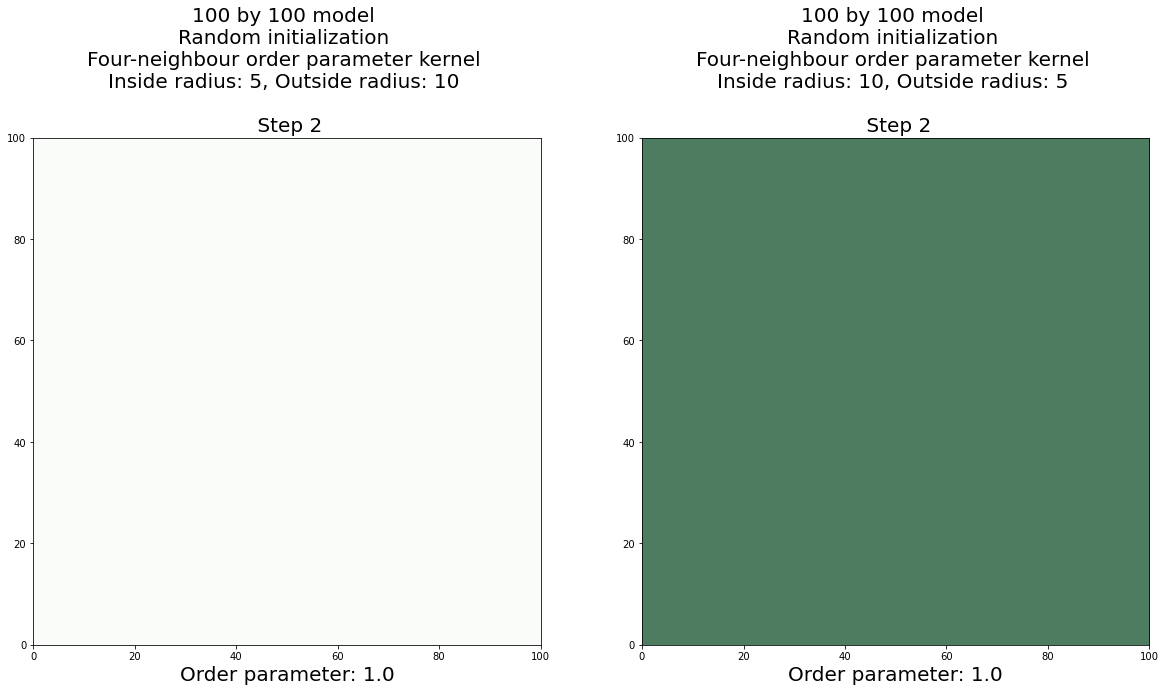

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('')

world = ReactionDiffusion(100, 5, 10, True, True)
random_par = 'Random' if world.random else 'Segregated'
neighbour_str = 'Four-neighbour' if world.static_neighbours else 'Dynamic-size'
n, m = world.array.shape
options = {'cmap':'Greens', 'alpha':0.7, 'vmin':0, 'vmax':1, 'interpolation':'none', 'origin':'upper', 'extent':[0, m, 0, n]}

world.loop(2)
ax1.imshow(world.array, **options)
ax1.set_title(f'{world.n} by {world.n} model \n{random_par} initialization \n{neighbour_str} order parameter kernel \nInside radius: {world.r_i}, Outside radius: {world.r_o} \n\n Step {world.steps}', fontsize=20)
ax1.set_xlabel(f'Order parameter: {world.order_parameter}', fontsize=20)


world = ReactionDiffusion(100, 10, 5, True, True)
random_par = 'Random' if world.random else 'Segregated'
neighbour_str = 'Four-neighbour' if world.static_neighbours else 'Dynamic-size'
n, m = world.array.shape
options = {'cmap':'Greens', 'alpha':0.7, 'vmin':0, 'vmax':1, 'interpolation':'none', 'origin':'upper', 'extent':[0, m, 0, n]}

world.loop(2)
ax2.imshow(world.array, **options)
ax2.set_title(f'{world.n} by {world.n} model \n{random_par} initialization \n{neighbour_str} order parameter kernel \nInside radius: {world.r_i}, Outside radius: {world.r_o} \n\n Step {world.steps}', fontsize=20)
ax2.set_xlabel(f'Order parameter: {world.order_parameter}', fontsize=20)

plt.show()

#### Example simulation of a Reaction-DIffusion model with arbitrary parameters

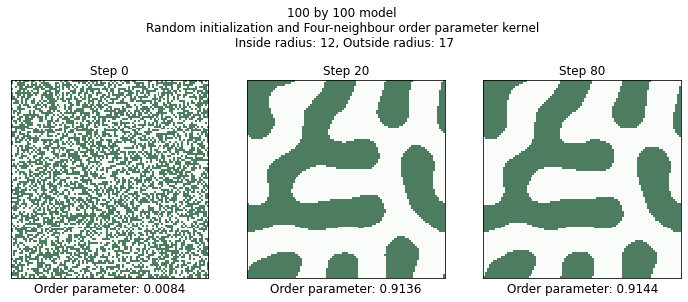

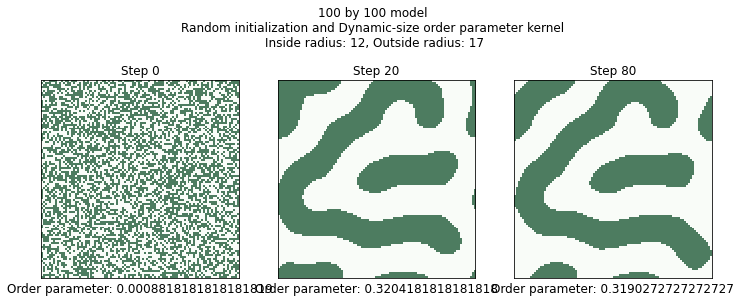

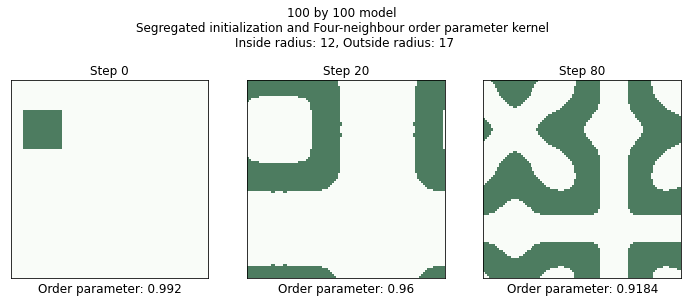

In [10]:
world = ReactionDiffusion(100, 12, 17, True, True)
three_frame(world, [0, 20, 80])

world = ReactionDiffusion(100, 12, 17, True, False)
three_frame(world, [0, 20, 80])

world = ReactionDiffusion(100, 12, 17, False, True)
three_frame(world, [0, 20, 80])

#### Example simulation of a Reaction-DIffusion model with many parameters by making use of the method possible_radii

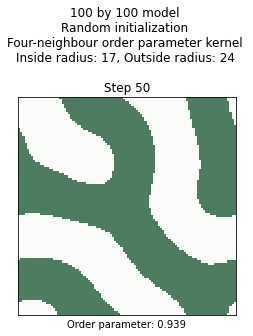

In [11]:
radii = possible_radii_calc(5)

for ri, ro in radii:
    a = ReactionDiffusion(100,ri,ro,True,True)
    a.animate(50)

## 2) Evaluation and plotting methods

### 2.0 Helper methods to plot order parameter evolution and simulation

In [12]:
def animate_threeframe(world, steps, frames):
    world2 = copy.deepcopy(world)
    
    world.animate(steps)
    three_frame(world2, frames)

In [13]:
def multi_2D_plotting(list_of_orders, legend, title = ""):  
    for i in list_of_orders:
        plt.plot(i)
    ax = plt.axes()
    ax.set(ylim=(0, 1))
    plt.legend(legend, loc='upper right')
    plt.title(title)
    plt.show()
    
def multi_2D_plotting_horizontal(list_of_orders_avg, list_of_orders_median, legend, title='', save=''):  
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    fig.suptitle(title)
    
    for i in list_of_orders_avg:
        ax1.plot(i)
    for j in list_of_orders_median:
        ax2.plot(j)
        
    ax1.set(ylim=(0, 1), xlabel='Steps', ylabel='Order parameter value', title='Average over 10 iterations')
    ax2.set(ylim=(0, 1), xlabel='Steps', ylabel='Order parameter value', title='Median over 10 iterations')
    
    ax1.legend(legend, loc='lower right')
    ax2.legend(legend, loc='lower right')
    
    if save != '':
        savefig(save, transparent=False, facecolor='white')
    plt.show()


### 2.1 Phase transition plot over all possible r_i and r_o

This plot will iterate over all possible values that r_i and r_o can take and plot only those who don't converge to 1, meaning those values that give out an unbalanced kernel and make the state fully activated or diffused.

#### Generate data 

In [14]:
n = 21
iterations = 1
combinations = [[True, True],[True, False],[False, True],[False, False]]


# Order parameter data computed
top = []
valid_parameters = []
title = []


for comb, (random, static_neighbours) in enumerate(tqdm(combinations, desc='Iterating over all possible parameter values')):  
    top.append([])
    valid_parameters.append([])
    for i in tqdm(range(1,n), desc='Iterating over all x'):
        for j in tqdm(range(1,n), desc=f'Iterating over all y with x: {i}'):
            runs = []
            for iteration in range(iterations):
                a = ReactionDiffusion(100, i, j, random, static_neighbours)
                a.step()
                a.step()
                
                for k in range(100):
                    if(a.order_parameter == 1):
                        continue
                    if(a.order_parameter == a.order_list[-2] and a.order_parameter == a.order_list[-3]):
                        continue
                    if(a.order_parameter == a.order_list[-3]):
                        continue               
                    a.step()  
                else:
                    runs.append(a.order_parameter)

            order_parameter = np.mean(runs)
            if order_parameter == 1:
                top[comb].append(0)
            else:
                top[comb].append(order_parameter)
                valid_parameters[comb].append((i,j))

    random_str = 'Random' if random else 'Segregated' 
    neighbour_str = 'four-neighbour' if static_neighbours else 'dynamic-size' 
    title.append(f'{random_str} initialization and \n{neighbour_str} order parameter kernel.')



#### Generate phase-transition plot


Saving figure to file figs/PhaseTransition/phase_transition_1_iterations


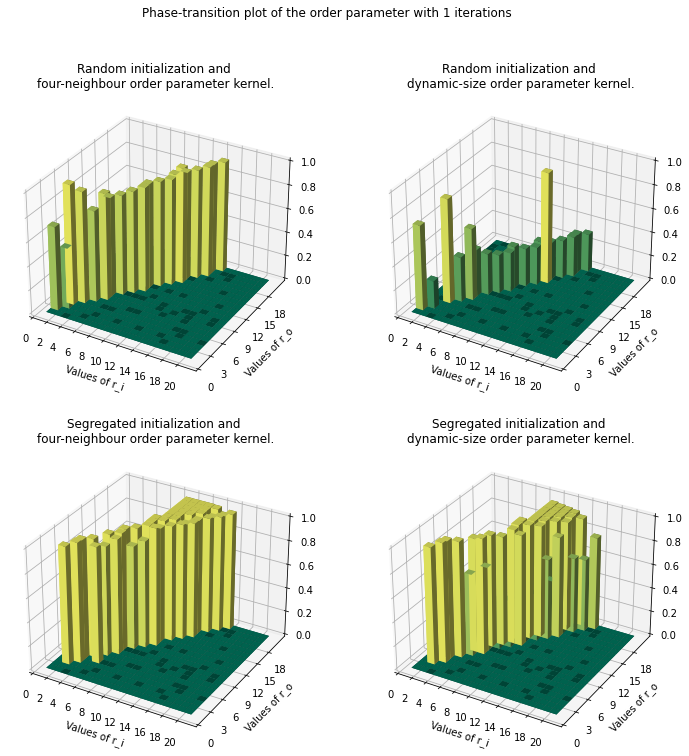

In [15]:
# set up the range that the data will take
width = depth = 1
_x = np.arange(1,n)
_y = np.arange(1,n)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()


# set up the figure and axes
fig = plt.figure(figsize=(12, 12))
fig.suptitle(f'Phase-transition plot of the order parameter with {iterations} iterations')

for i in range(4):
    bottom = np.zeros_like(top[i])
    data = top[i]
    dataT = np.array(data).reshape((n-1, n-1))
    dataT = dataT.T
    dataT = dataT.reshape(-1)

    index = 221 + i
    ax = fig.add_subplot(index, projection='3d')
 
    # set up the colors of the plot
    cmap = cm.get_cmap('summer') # Get desired colormap - you can change this!
    max_height = np.max(dataT)   # get range of colorbars so we can normalize
    min_height = np.min(dataT)
    #     scale each z to [0,1], and get their rgb values
    rgba = [cmap((k-min_height)/max_height) for k in dataT] 
        
    # Chart the data in the corresponding plot
    ax.bar3d(x, y, bottom, width, depth, dataT, color = rgba, shade=True)
        
    ax.set(xlabel='Values of r_i', ylabel='Values of r_o', title=title[i])
    ax.xaxis.set_ticks(np.arange(0, n, 2))
    ax.yaxis.set_ticks(np.arange(0, n, 3))
    ax.zaxis.set_ticks(np.arange(0, 1.1, 0.2))
    
    
savefig(f'figs/PhaseTransition/phase_transition_{iterations}_iterations', transparent=False, facecolor='white')
plt.show()

### 2.2 Linear regression of the values to the predicted line

The equation that should give balanced values of r_i (x) and r_o (y) is plotted as y = sqrt(2) * x

In [18]:
# Equation given by y = sqrt(2) * x
class Line():
    def __init__(self, m = np.sqrt(2), b = 0):
        self.m = m
        self.b = b
        
    def calculate_y(self, x):
        return self.m * x + self.b
    
    def distance_to_point(self, point):
        # We define the line as ax + by + c = 0 -> -np.sqrt(2)*x + y = 0      
        # distance = np.abs(a*x_0 + b*y_0 + c) / np.sqrt(a**2 + b**2)
        
        return float(np.abs(-np.sqrt(2) * point[0] + point[1]) / np.sqrt(3))

line = Line()

Saving figure to file figs/DistancePlot/linear_regr_Random_Four-neighbor


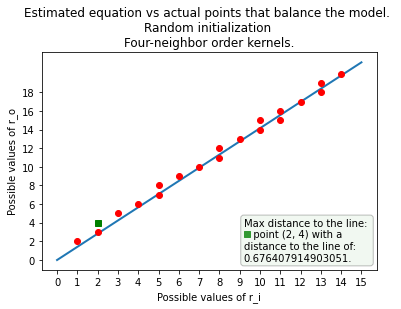

Saving figure to file figs/DistancePlot/linear_regr_Random_Dynamic-neighbor


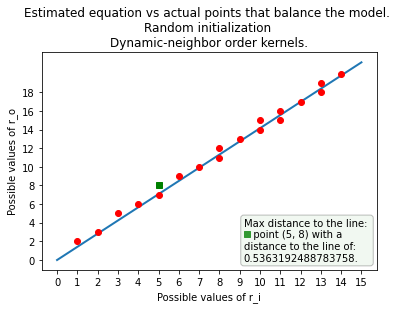

Saving figure to file figs/DistancePlot/linear_regr_Segregated_Four-neighbor


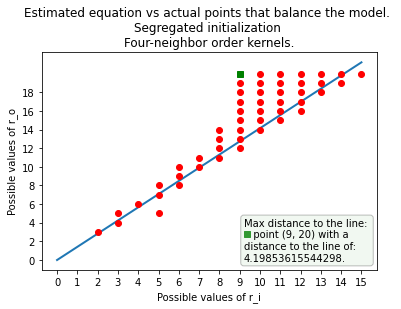

Saving figure to file figs/DistancePlot/linear_regr_Segregated_Dynamic-neighbor


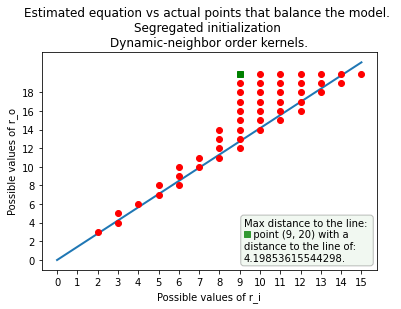

In [19]:
for i in range(4):
    title = {
        0: ('Random', 'Four-neighbor'),
        1: ('Random', 'Dynamic-neighbor'),
        2: ('Segregated', 'Four-neighbor'),
        3: ('Segregated', 'Dynamic-neighbor')
    }
    valid_parameters2 = np.array(valid_parameters[i])

    distances = [line.distance_to_point(x) for x in valid_parameters2]
    max_distance = np.amax([distances])
    max_pair = valid_parameters2[np.argmax(distances)]

    # Take the tuple with the highest distance to the line from the list of red plottable points
    mask = np.logical_and(np.any([valid_parameters2[0:, 0]] == max_pair[0], axis = 0),
                          np.any([valid_parameters2[0:, 1]] == max_pair[1], axis = 0))
    valid_parameters3 = valid_parameters2[~mask]

    plt.plot([line.calculate_y(x) for x in range(16)])
    plt.plot([t[0] for t in valid_parameters3], [t[1] for t in valid_parameters3], 'ro')
    plt.plot(max_pair[0], max_pair[1], 'gs')


    plt.xlabel('Possible values of r_i')
    plt.ylabel('Possible values of r_o')
    plt.xticks(np.arange(0, 21, 1))
    plt.yticks(np.arange(0, 20, 2))

    plt.title(f'Estimated equation vs actual points that balance the model. \n{title[i][0]} initialization \n{title[i][1]} order kernels.')
    props = dict(boxstyle='round', facecolor='#C8E6C9', alpha=0.25)

    plt.plot(9.35, 2.75, 'gs')
    text = 'Max distance to the line: \n   point (' + str(max_pair[0]) + ', ' + str(max_pair[1]) + ') with a \ndistance to the line of: \n' + str(max_distance) + '.' 
    plt.text(9.2, 4.5, text, fontsize=10,
            verticalalignment='top', horizontalalignment='left', bbox=props)

    savefig(f'figs/DistancePlot/linear_regr_{title[i][0]}_{title[i][1]}', transparent=False, facecolor='white')
    plt.show()

### 2.3 Evolution plots

Two different boolean variables with four different combinations:

 - random: if true, the world will be initialized randomly into 1s and 0s. Otherwise, a patch of activator will be set at a random point in the CA.
 - static_neighbours: whether the kernel for calculating the order parameter will be static or not: if set to true, a kernel with only the 4 closest neighbours will be used. Otherwise, a kernel of size 2*r_o will be used, with all elements inside r_i set to 1.
 
All the combinations will be tried and the order parameter plots will be computed for each case.



Saving figure to file figs/OrderEvolution/evolution_plot_random_four-neighbour


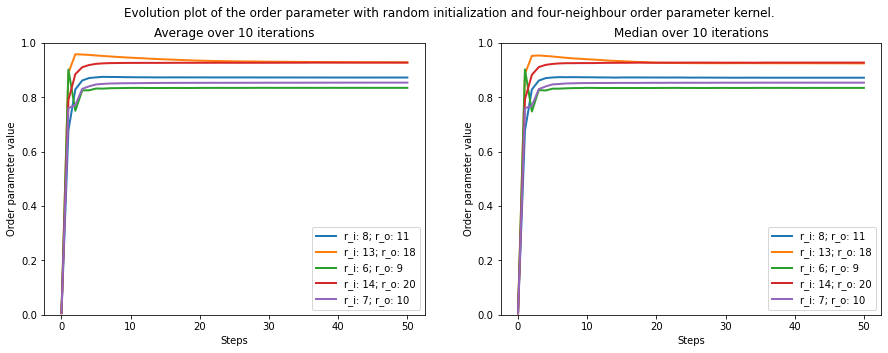



Saving figure to file figs/OrderEvolution/evolution_plot_random_dynamic-size


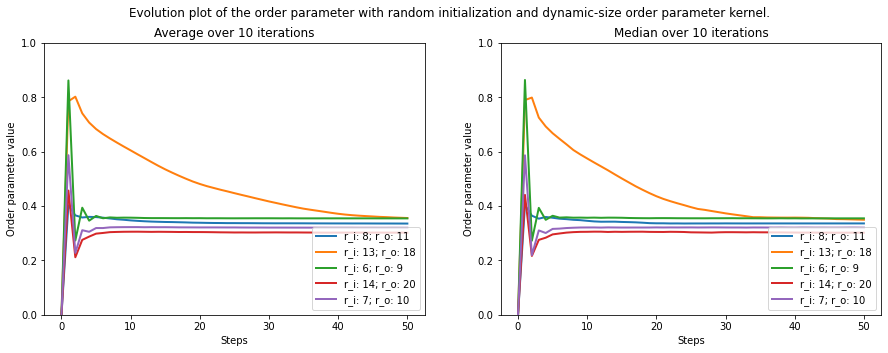



Saving figure to file figs/OrderEvolution/evolution_plot_segregated_four-neighbour


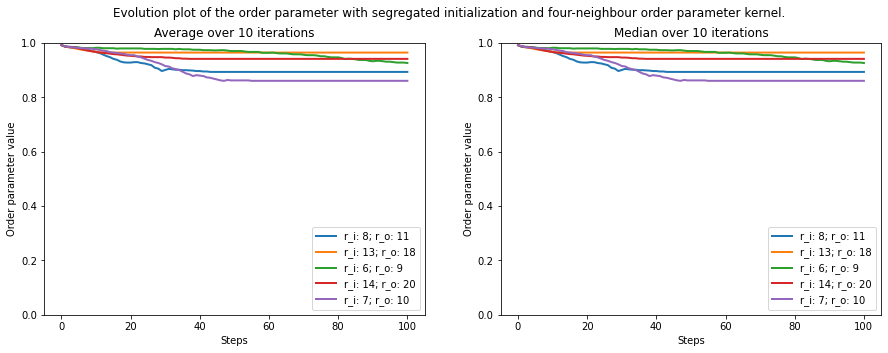



Saving figure to file figs/OrderEvolution/evolution_plot_segregated_dynamic-size


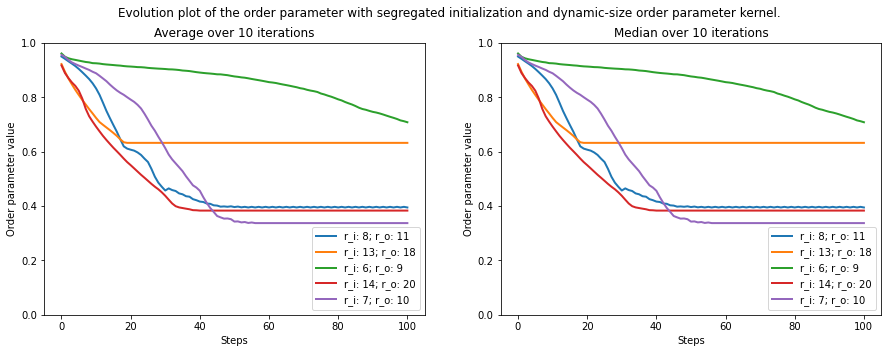

In [23]:
combinations = np.array(valid_parameters[0][4:])
possible_radii = combinations[np.random.choice(len(combinations), 5, replace=False)]

combinations = [[True, True],[True, False],[False, True],[False, False]]

for i, (random, static_neighbours) in enumerate(tqdm(combinations, desc='Iterating over all possible parameter values')):  
    list_of_orders = []
    legend = []
    for j, (r_i, r_o) in enumerate(tqdm(possible_radii, desc='Calculating for each pair of possible values:')):
        list_of_orders.append([])
        for iteration in tqdm(range(10), desc=f'Iterating 10 times over r_i: {r_i} and r_o: {r_o}'):
            a = ReactionDiffusion(100, r_i, r_o, random=random, static_neighbours=static_neighbours)
            if random:
                a.loop(50)
            else:
                a.loop(100)
            list_of_orders[j].append(a.order_list)
        legend.append("r_i: " + str(a.r_i) + "; r_o: " + str(a.r_o))

    list_of_orders_average = np.mean(list_of_orders, axis = 1)
    list_of_orders_median = np.median(list_of_orders, axis = 1)
    
    random_str = 'random' if random else 'segregated' 
    neighbour_str = 'four-neighbour' if static_neighbours else 'dynamic-size' 
    title = 'Evolution plot of the order parameter with ' + random_str + ' initialization and ' + neighbour_str + ' order parameter kernel.'
    savepath = f'figs/OrderEvolution/evolution_plot_{title.split(" ")[7]}_{title.split(" ")[10]}'
     
#     multi_2D_plotting(list_of_orders_average, legend, 'Average')
#     multi_2D_plotting(list_of_orders_median, legend, 'Median')
    multi_2D_plotting_horizontal(list_of_orders_average, list_of_orders_median, legend, title, savepath)
    
#     savefig('figs/ordparsegr' + str(r_i) + str(r_o), transparent=False, facecolor='white')


### 2.4 Asserting validity of the model for bigger r_i and r_o

We will simulate a setting with higher r_i and r_o according to the line theorized to provide the desired values.
Our maximum values for a world of 100x100 are 20, so the ratio of r_i to n is maximum of 1/4. We will use a world size that keeps this ratio going: so, given an arbitrarily chosen r_i, we will choose the rest of the parameters as r_o = f(x) = np.sqrt(2) * r_i, and n = 4 * r_i

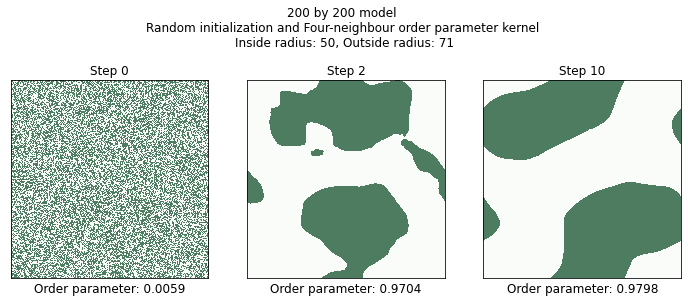

In [24]:
# We set our r_i to be 50
r_i = 50
r_o = int(np.ceil(line.calculate_y(r_i)))
n = r_i * 4
n = 200

a = ReactionDiffusion(n, r_i, r_o, True, True)
three_frame(a, [0,2,10])

## 3 Classifying the shapes generated in the model according to area

With random initialization, the model generates different shapes: green spheres, white spheres, tubes, and mixed. A simulation will be ran a number of iterations and it will be manually classified into the kind of shapes generated. 

### Showing categories

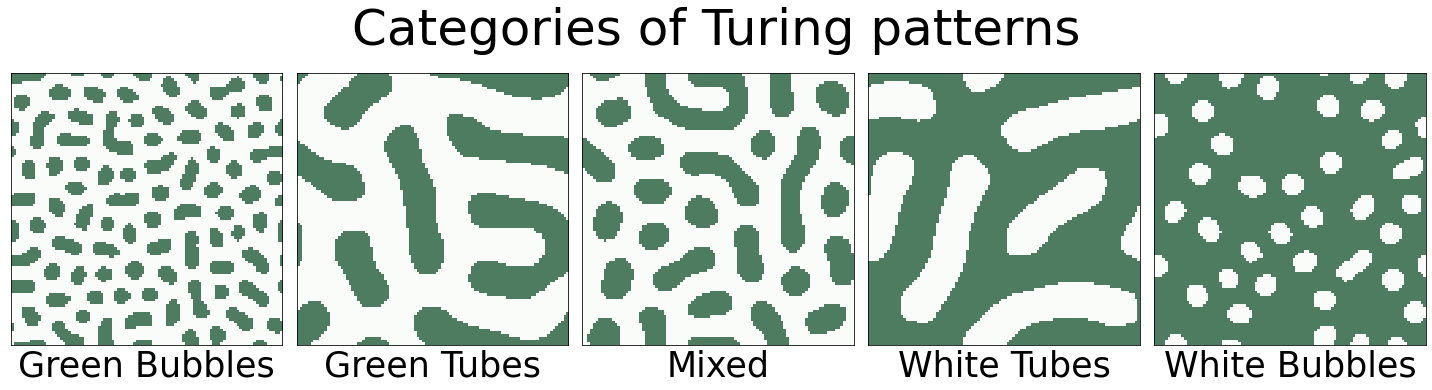

In [25]:
examples = [(4,6), (10,15), (7,10), (11,15), (5,7)]
categories = ['Green Bubbles', 'Green Tubes', 'Mixed', 'White Tubes', 'White Bubbles']

plt.figure(figsize=(20, 5))
plt.suptitle('Categories of Turing patterns', size=50)

for i, n in enumerate(examples):
    plt.subplot(1, 5, i+1)
    plt.xlabel(categories[i], size=35)
    
    world = ReactionDiffusion(100, n[0], n[1])
    world.loop(50)

    n, m = world.array.shape
    options = underride(options,
                        cmap='Greens',
                        alpha=0.7,
                        vmin=0, vmax=1, 
                        interpolation='none', 
                        origin='upper',
                        extent=[0, m, 0, n])

    plt.axis([0, m, 0, n])
    plt.xticks([])
    plt.yticks([])

    plt.imshow(world.array, **options)
    
plt.tight_layout()

### Plotting order parameter

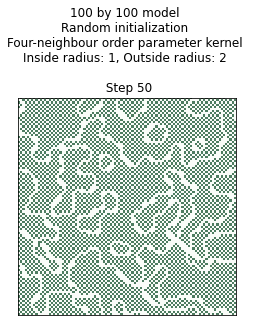

Button(description='Green Bubbles; (1, 2, 0)', style=ButtonStyle())

Button(description='Green Tubes; (1, 2, 0)', style=ButtonStyle())

Button(description='Mixed; (1, 2, 0)', style=ButtonStyle())

Button(description='White Bubbles; (1, 2, 0)', style=ButtonStyle())

Button(description='White Tubes; (1, 2, 0)', style=ButtonStyle())

Button(description='Error; (1, 2, 0)', style=ButtonStyle())

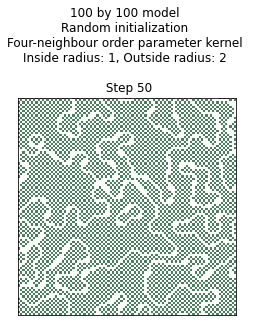

Button(description='Green Bubbles; (1, 2, 1)', style=ButtonStyle())

Button(description='Green Tubes; (1, 2, 1)', style=ButtonStyle())

Button(description='Mixed; (1, 2, 1)', style=ButtonStyle())

Button(description='White Bubbles; (1, 2, 1)', style=ButtonStyle())

Button(description='White Tubes; (1, 2, 1)', style=ButtonStyle())

Button(description='Error; (1, 2, 1)', style=ButtonStyle())

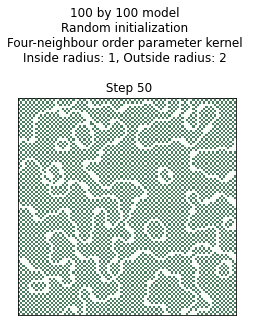

Button(description='Green Bubbles; (1, 2, 2)', style=ButtonStyle())

Button(description='Green Tubes; (1, 2, 2)', style=ButtonStyle())

Button(description='Mixed; (1, 2, 2)', style=ButtonStyle())

Button(description='White Bubbles; (1, 2, 2)', style=ButtonStyle())

Button(description='White Tubes; (1, 2, 2)', style=ButtonStyle())

Button(description='Error; (1, 2, 2)', style=ButtonStyle())

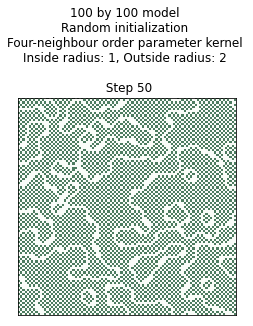

Button(description='Green Bubbles; (1, 2, 3)', style=ButtonStyle())

Button(description='Green Tubes; (1, 2, 3)', style=ButtonStyle())

Button(description='Mixed; (1, 2, 3)', style=ButtonStyle())

Button(description='White Bubbles; (1, 2, 3)', style=ButtonStyle())

Button(description='White Tubes; (1, 2, 3)', style=ButtonStyle())

Button(description='Error; (1, 2, 3)', style=ButtonStyle())

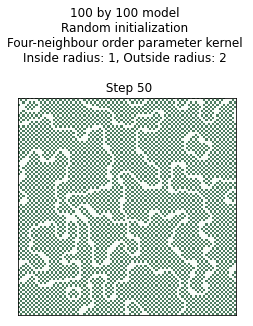

Button(description='Green Bubbles; (1, 2, 4)', style=ButtonStyle())

Button(description='Green Tubes; (1, 2, 4)', style=ButtonStyle())

Button(description='Mixed; (1, 2, 4)', style=ButtonStyle())

Button(description='White Bubbles; (1, 2, 4)', style=ButtonStyle())

Button(description='White Tubes; (1, 2, 4)', style=ButtonStyle())

Button(description='Error; (1, 2, 4)', style=ButtonStyle())

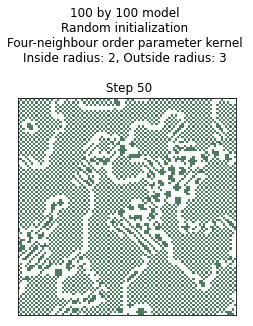

Button(description='Green Bubbles; (2, 3, 0)', style=ButtonStyle())

Button(description='Green Tubes; (2, 3, 0)', style=ButtonStyle())

Button(description='Mixed; (2, 3, 0)', style=ButtonStyle())

Button(description='White Bubbles; (2, 3, 0)', style=ButtonStyle())

Button(description='White Tubes; (2, 3, 0)', style=ButtonStyle())

Button(description='Error; (2, 3, 0)', style=ButtonStyle())

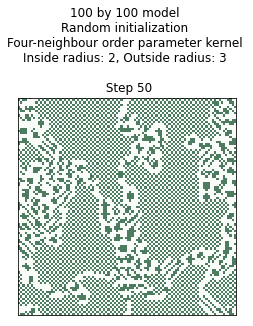

Button(description='Green Bubbles; (2, 3, 1)', style=ButtonStyle())

Button(description='Green Tubes; (2, 3, 1)', style=ButtonStyle())

Button(description='Mixed; (2, 3, 1)', style=ButtonStyle())

Button(description='White Bubbles; (2, 3, 1)', style=ButtonStyle())

Button(description='White Tubes; (2, 3, 1)', style=ButtonStyle())

Button(description='Error; (2, 3, 1)', style=ButtonStyle())

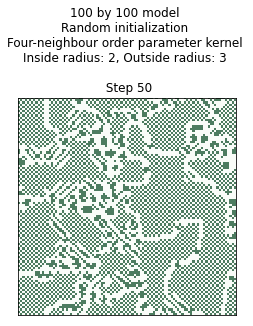

Button(description='Green Bubbles; (2, 3, 2)', style=ButtonStyle())

Button(description='Green Tubes; (2, 3, 2)', style=ButtonStyle())

Button(description='Mixed; (2, 3, 2)', style=ButtonStyle())

Button(description='White Bubbles; (2, 3, 2)', style=ButtonStyle())

Button(description='White Tubes; (2, 3, 2)', style=ButtonStyle())

Button(description='Error; (2, 3, 2)', style=ButtonStyle())

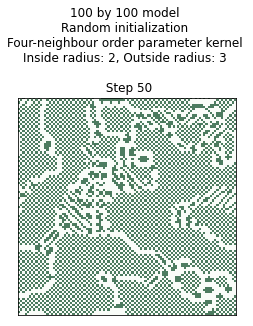

Button(description='Green Bubbles; (2, 3, 3)', style=ButtonStyle())

Button(description='Green Tubes; (2, 3, 3)', style=ButtonStyle())

Button(description='Mixed; (2, 3, 3)', style=ButtonStyle())

Button(description='White Bubbles; (2, 3, 3)', style=ButtonStyle())

Button(description='White Tubes; (2, 3, 3)', style=ButtonStyle())

Button(description='Error; (2, 3, 3)', style=ButtonStyle())

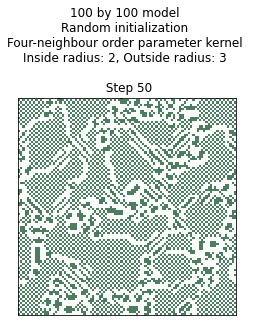

Button(description='Green Bubbles; (2, 3, 4)', style=ButtonStyle())

Button(description='Green Tubes; (2, 3, 4)', style=ButtonStyle())

Button(description='Mixed; (2, 3, 4)', style=ButtonStyle())

Button(description='White Bubbles; (2, 3, 4)', style=ButtonStyle())

Button(description='White Tubes; (2, 3, 4)', style=ButtonStyle())

Button(description='Error; (2, 3, 4)', style=ButtonStyle())

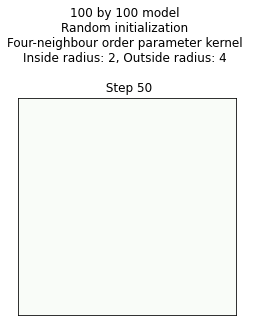

Button(description='Green Bubbles; (2, 4, 0)', style=ButtonStyle())

Button(description='Green Tubes; (2, 4, 0)', style=ButtonStyle())

Button(description='Mixed; (2, 4, 0)', style=ButtonStyle())

Button(description='White Bubbles; (2, 4, 0)', style=ButtonStyle())

Button(description='White Tubes; (2, 4, 0)', style=ButtonStyle())

Button(description='Error; (2, 4, 0)', style=ButtonStyle())

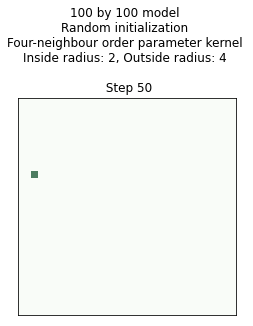

Button(description='Green Bubbles; (2, 4, 1)', style=ButtonStyle())

Button(description='Green Tubes; (2, 4, 1)', style=ButtonStyle())

Button(description='Mixed; (2, 4, 1)', style=ButtonStyle())

Button(description='White Bubbles; (2, 4, 1)', style=ButtonStyle())

Button(description='White Tubes; (2, 4, 1)', style=ButtonStyle())

Button(description='Error; (2, 4, 1)', style=ButtonStyle())

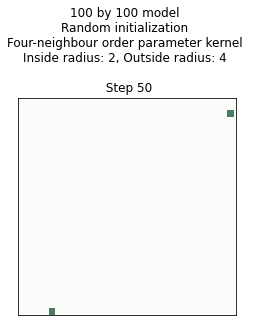

Button(description='Green Bubbles; (2, 4, 2)', style=ButtonStyle())

Button(description='Green Tubes; (2, 4, 2)', style=ButtonStyle())

Button(description='Mixed; (2, 4, 2)', style=ButtonStyle())

Button(description='White Bubbles; (2, 4, 2)', style=ButtonStyle())

Button(description='White Tubes; (2, 4, 2)', style=ButtonStyle())

Button(description='Error; (2, 4, 2)', style=ButtonStyle())

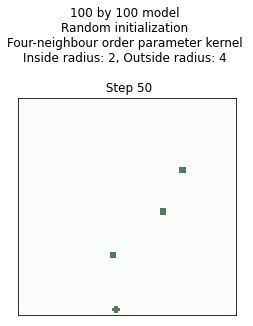

Button(description='Green Bubbles; (2, 4, 3)', style=ButtonStyle())

Button(description='Green Tubes; (2, 4, 3)', style=ButtonStyle())

Button(description='Mixed; (2, 4, 3)', style=ButtonStyle())

Button(description='White Bubbles; (2, 4, 3)', style=ButtonStyle())

Button(description='White Tubes; (2, 4, 3)', style=ButtonStyle())

Button(description='Error; (2, 4, 3)', style=ButtonStyle())

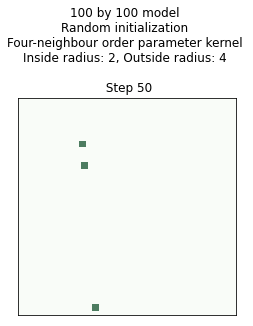

Button(description='Green Bubbles; (2, 4, 4)', style=ButtonStyle())

Button(description='Green Tubes; (2, 4, 4)', style=ButtonStyle())

Button(description='Mixed; (2, 4, 4)', style=ButtonStyle())

Button(description='White Bubbles; (2, 4, 4)', style=ButtonStyle())

Button(description='White Tubes; (2, 4, 4)', style=ButtonStyle())

Button(description='Error; (2, 4, 4)', style=ButtonStyle())

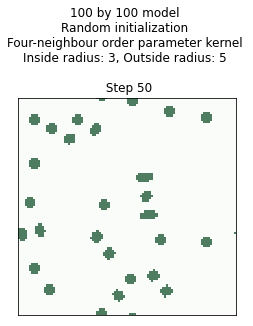

Button(description='Green Bubbles; (3, 5, 0)', style=ButtonStyle())

Button(description='Green Tubes; (3, 5, 0)', style=ButtonStyle())

Button(description='Mixed; (3, 5, 0)', style=ButtonStyle())

Button(description='White Bubbles; (3, 5, 0)', style=ButtonStyle())

Button(description='White Tubes; (3, 5, 0)', style=ButtonStyle())

Button(description='Error; (3, 5, 0)', style=ButtonStyle())

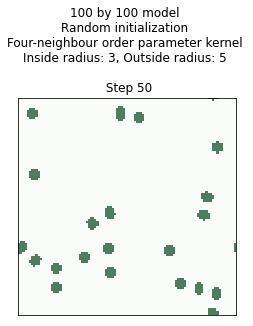

Button(description='Green Bubbles; (3, 5, 1)', style=ButtonStyle())

Button(description='Green Tubes; (3, 5, 1)', style=ButtonStyle())

Button(description='Mixed; (3, 5, 1)', style=ButtonStyle())

Button(description='White Bubbles; (3, 5, 1)', style=ButtonStyle())

Button(description='White Tubes; (3, 5, 1)', style=ButtonStyle())

Button(description='Error; (3, 5, 1)', style=ButtonStyle())

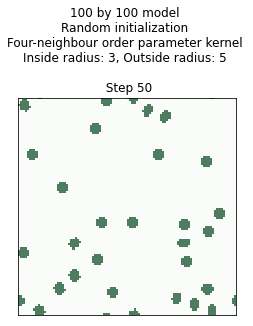

Button(description='Green Bubbles; (3, 5, 2)', style=ButtonStyle())

Button(description='Green Tubes; (3, 5, 2)', style=ButtonStyle())

Button(description='Mixed; (3, 5, 2)', style=ButtonStyle())

Button(description='White Bubbles; (3, 5, 2)', style=ButtonStyle())

Button(description='White Tubes; (3, 5, 2)', style=ButtonStyle())

Button(description='Error; (3, 5, 2)', style=ButtonStyle())

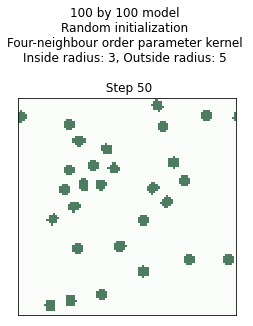

Button(description='Green Bubbles; (3, 5, 3)', style=ButtonStyle())

Button(description='Green Tubes; (3, 5, 3)', style=ButtonStyle())

Button(description='Mixed; (3, 5, 3)', style=ButtonStyle())

Button(description='White Bubbles; (3, 5, 3)', style=ButtonStyle())

Button(description='White Tubes; (3, 5, 3)', style=ButtonStyle())

Button(description='Error; (3, 5, 3)', style=ButtonStyle())

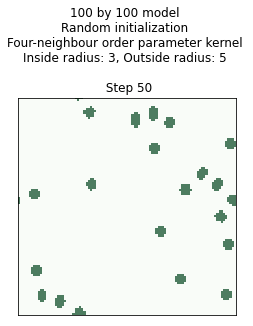

Button(description='Green Bubbles; (3, 5, 4)', style=ButtonStyle())

Button(description='Green Tubes; (3, 5, 4)', style=ButtonStyle())

Button(description='Mixed; (3, 5, 4)', style=ButtonStyle())

Button(description='White Bubbles; (3, 5, 4)', style=ButtonStyle())

Button(description='White Tubes; (3, 5, 4)', style=ButtonStyle())

Button(description='Error; (3, 5, 4)', style=ButtonStyle())

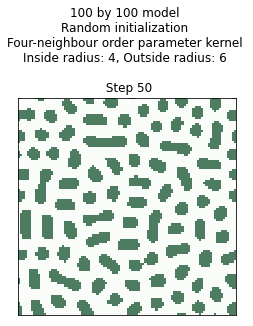

Button(description='Green Bubbles; (4, 6, 0)', style=ButtonStyle())

Button(description='Green Tubes; (4, 6, 0)', style=ButtonStyle())

Button(description='Mixed; (4, 6, 0)', style=ButtonStyle())

Button(description='White Bubbles; (4, 6, 0)', style=ButtonStyle())

Button(description='White Tubes; (4, 6, 0)', style=ButtonStyle())

Button(description='Error; (4, 6, 0)', style=ButtonStyle())

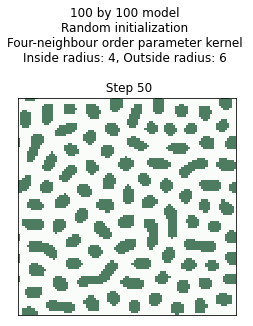

Button(description='Green Bubbles; (4, 6, 1)', style=ButtonStyle())

Button(description='Green Tubes; (4, 6, 1)', style=ButtonStyle())

Button(description='Mixed; (4, 6, 1)', style=ButtonStyle())

Button(description='White Bubbles; (4, 6, 1)', style=ButtonStyle())

Button(description='White Tubes; (4, 6, 1)', style=ButtonStyle())

Button(description='Error; (4, 6, 1)', style=ButtonStyle())

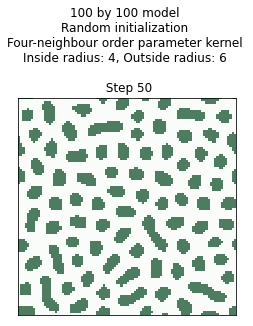

Button(description='Green Bubbles; (4, 6, 2)', style=ButtonStyle())

Button(description='Green Tubes; (4, 6, 2)', style=ButtonStyle())

Button(description='Mixed; (4, 6, 2)', style=ButtonStyle())

Button(description='White Bubbles; (4, 6, 2)', style=ButtonStyle())

Button(description='White Tubes; (4, 6, 2)', style=ButtonStyle())

Button(description='Error; (4, 6, 2)', style=ButtonStyle())

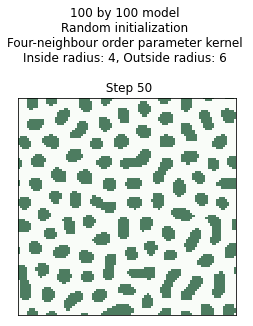

Button(description='Green Bubbles; (4, 6, 3)', style=ButtonStyle())

Button(description='Green Tubes; (4, 6, 3)', style=ButtonStyle())

Button(description='Mixed; (4, 6, 3)', style=ButtonStyle())

Button(description='White Bubbles; (4, 6, 3)', style=ButtonStyle())

Button(description='White Tubes; (4, 6, 3)', style=ButtonStyle())

Button(description='Error; (4, 6, 3)', style=ButtonStyle())

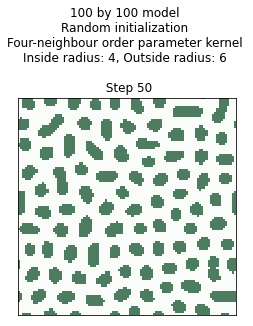

Button(description='Green Bubbles; (4, 6, 4)', style=ButtonStyle())

Button(description='Green Tubes; (4, 6, 4)', style=ButtonStyle())

Button(description='Mixed; (4, 6, 4)', style=ButtonStyle())

Button(description='White Bubbles; (4, 6, 4)', style=ButtonStyle())

Button(description='White Tubes; (4, 6, 4)', style=ButtonStyle())

Button(description='Error; (4, 6, 4)', style=ButtonStyle())

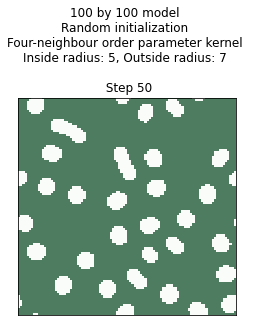

Button(description='Green Bubbles; (5, 7, 0)', style=ButtonStyle())

Button(description='Green Tubes; (5, 7, 0)', style=ButtonStyle())

Button(description='Mixed; (5, 7, 0)', style=ButtonStyle())

Button(description='White Bubbles; (5, 7, 0)', style=ButtonStyle())

Button(description='White Tubes; (5, 7, 0)', style=ButtonStyle())

Button(description='Error; (5, 7, 0)', style=ButtonStyle())

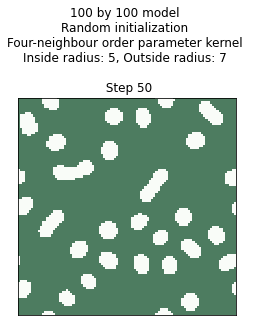

Button(description='Green Bubbles; (5, 7, 1)', style=ButtonStyle())

Button(description='Green Tubes; (5, 7, 1)', style=ButtonStyle())

Button(description='Mixed; (5, 7, 1)', style=ButtonStyle())

Button(description='White Bubbles; (5, 7, 1)', style=ButtonStyle())

Button(description='White Tubes; (5, 7, 1)', style=ButtonStyle())

Button(description='Error; (5, 7, 1)', style=ButtonStyle())

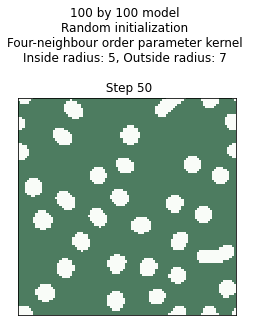

Button(description='Green Bubbles; (5, 7, 2)', style=ButtonStyle())

Button(description='Green Tubes; (5, 7, 2)', style=ButtonStyle())

Button(description='Mixed; (5, 7, 2)', style=ButtonStyle())

Button(description='White Bubbles; (5, 7, 2)', style=ButtonStyle())

Button(description='White Tubes; (5, 7, 2)', style=ButtonStyle())

Button(description='Error; (5, 7, 2)', style=ButtonStyle())

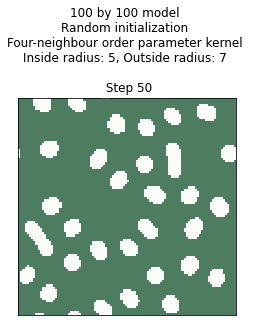

Button(description='Green Bubbles; (5, 7, 3)', style=ButtonStyle())

Button(description='Green Tubes; (5, 7, 3)', style=ButtonStyle())

Button(description='Mixed; (5, 7, 3)', style=ButtonStyle())

Button(description='White Bubbles; (5, 7, 3)', style=ButtonStyle())

Button(description='White Tubes; (5, 7, 3)', style=ButtonStyle())

Button(description='Error; (5, 7, 3)', style=ButtonStyle())

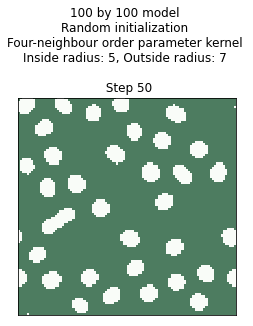

Button(description='Green Bubbles; (5, 7, 4)', style=ButtonStyle())

Button(description='Green Tubes; (5, 7, 4)', style=ButtonStyle())

Button(description='Mixed; (5, 7, 4)', style=ButtonStyle())

Button(description='White Bubbles; (5, 7, 4)', style=ButtonStyle())

Button(description='White Tubes; (5, 7, 4)', style=ButtonStyle())

Button(description='Error; (5, 7, 4)', style=ButtonStyle())

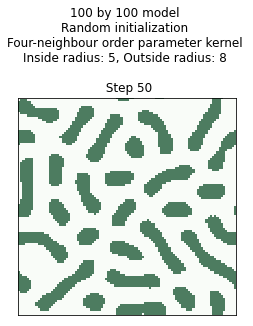

Button(description='Green Bubbles; (5, 8, 0)', style=ButtonStyle())

Button(description='Green Tubes; (5, 8, 0)', style=ButtonStyle())

Button(description='Mixed; (5, 8, 0)', style=ButtonStyle())

Button(description='White Bubbles; (5, 8, 0)', style=ButtonStyle())

Button(description='White Tubes; (5, 8, 0)', style=ButtonStyle())

Button(description='Error; (5, 8, 0)', style=ButtonStyle())

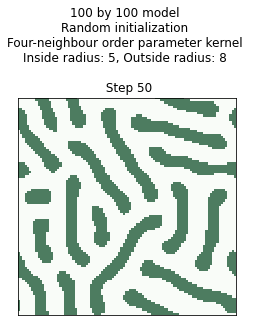

Button(description='Green Bubbles; (5, 8, 1)', style=ButtonStyle())

Button(description='Green Tubes; (5, 8, 1)', style=ButtonStyle())

Button(description='Mixed; (5, 8, 1)', style=ButtonStyle())

Button(description='White Bubbles; (5, 8, 1)', style=ButtonStyle())

Button(description='White Tubes; (5, 8, 1)', style=ButtonStyle())

Button(description='Error; (5, 8, 1)', style=ButtonStyle())

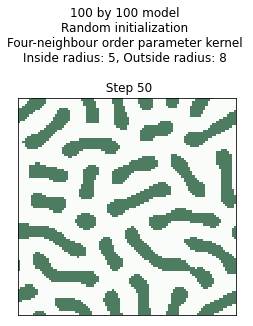

Button(description='Green Bubbles; (5, 8, 2)', style=ButtonStyle())

Button(description='Green Tubes; (5, 8, 2)', style=ButtonStyle())

Button(description='Mixed; (5, 8, 2)', style=ButtonStyle())

Button(description='White Bubbles; (5, 8, 2)', style=ButtonStyle())

Button(description='White Tubes; (5, 8, 2)', style=ButtonStyle())

Button(description='Error; (5, 8, 2)', style=ButtonStyle())

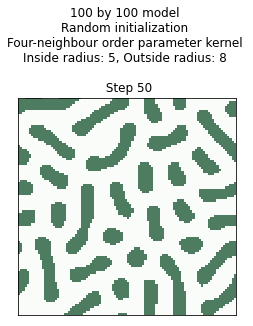

Button(description='Green Bubbles; (5, 8, 3)', style=ButtonStyle())

Button(description='Green Tubes; (5, 8, 3)', style=ButtonStyle())

Button(description='Mixed; (5, 8, 3)', style=ButtonStyle())

Button(description='White Bubbles; (5, 8, 3)', style=ButtonStyle())

Button(description='White Tubes; (5, 8, 3)', style=ButtonStyle())

Button(description='Error; (5, 8, 3)', style=ButtonStyle())

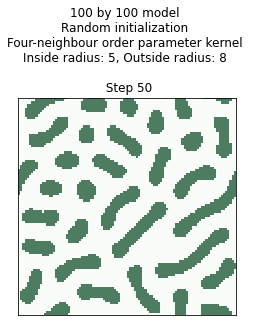

Button(description='Green Bubbles; (5, 8, 4)', style=ButtonStyle())

Button(description='Green Tubes; (5, 8, 4)', style=ButtonStyle())

Button(description='Mixed; (5, 8, 4)', style=ButtonStyle())

Button(description='White Bubbles; (5, 8, 4)', style=ButtonStyle())

Button(description='White Tubes; (5, 8, 4)', style=ButtonStyle())

Button(description='Error; (5, 8, 4)', style=ButtonStyle())

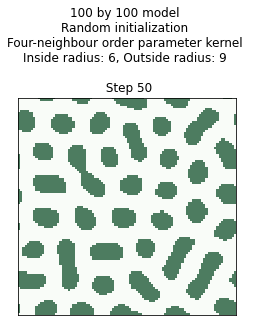

Button(description='Green Bubbles; (6, 9, 0)', style=ButtonStyle())

Button(description='Green Tubes; (6, 9, 0)', style=ButtonStyle())

Button(description='Mixed; (6, 9, 0)', style=ButtonStyle())

Button(description='White Bubbles; (6, 9, 0)', style=ButtonStyle())

Button(description='White Tubes; (6, 9, 0)', style=ButtonStyle())

Button(description='Error; (6, 9, 0)', style=ButtonStyle())

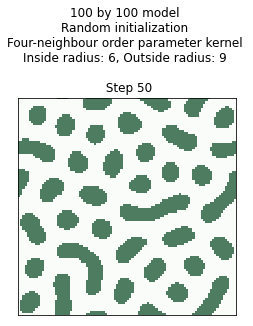

Button(description='Green Bubbles; (6, 9, 1)', style=ButtonStyle())

Button(description='Green Tubes; (6, 9, 1)', style=ButtonStyle())

Button(description='Mixed; (6, 9, 1)', style=ButtonStyle())

Button(description='White Bubbles; (6, 9, 1)', style=ButtonStyle())

Button(description='White Tubes; (6, 9, 1)', style=ButtonStyle())

Button(description='Error; (6, 9, 1)', style=ButtonStyle())

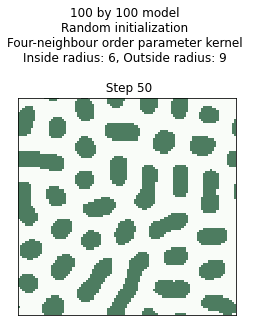

Button(description='Green Bubbles; (6, 9, 2)', style=ButtonStyle())

Button(description='Green Tubes; (6, 9, 2)', style=ButtonStyle())

Button(description='Mixed; (6, 9, 2)', style=ButtonStyle())

Button(description='White Bubbles; (6, 9, 2)', style=ButtonStyle())

Button(description='White Tubes; (6, 9, 2)', style=ButtonStyle())

Button(description='Error; (6, 9, 2)', style=ButtonStyle())

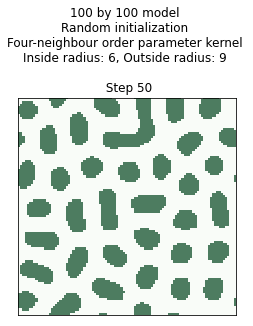

Button(description='Green Bubbles; (6, 9, 3)', style=ButtonStyle())

Button(description='Green Tubes; (6, 9, 3)', style=ButtonStyle())

Button(description='Mixed; (6, 9, 3)', style=ButtonStyle())

Button(description='White Bubbles; (6, 9, 3)', style=ButtonStyle())

Button(description='White Tubes; (6, 9, 3)', style=ButtonStyle())

Button(description='Error; (6, 9, 3)', style=ButtonStyle())

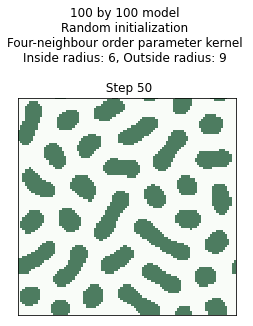

Button(description='Green Bubbles; (6, 9, 4)', style=ButtonStyle())

Button(description='Green Tubes; (6, 9, 4)', style=ButtonStyle())

Button(description='Mixed; (6, 9, 4)', style=ButtonStyle())

Button(description='White Bubbles; (6, 9, 4)', style=ButtonStyle())

Button(description='White Tubes; (6, 9, 4)', style=ButtonStyle())

Button(description='Error; (6, 9, 4)', style=ButtonStyle())

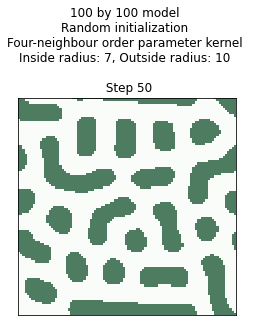

Button(description='Green Bubbles; (7, 10, 0)', style=ButtonStyle())

Button(description='Green Tubes; (7, 10, 0)', style=ButtonStyle())

Button(description='Mixed; (7, 10, 0)', style=ButtonStyle())

Button(description='White Bubbles; (7, 10, 0)', style=ButtonStyle())

Button(description='White Tubes; (7, 10, 0)', style=ButtonStyle())

Button(description='Error; (7, 10, 0)', style=ButtonStyle())

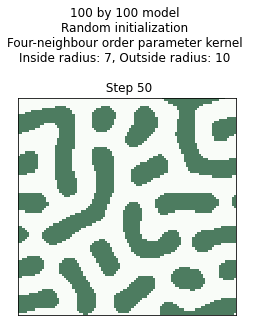

Button(description='Green Bubbles; (7, 10, 1)', style=ButtonStyle())

Button(description='Green Tubes; (7, 10, 1)', style=ButtonStyle())

Button(description='Mixed; (7, 10, 1)', style=ButtonStyle())

Button(description='White Bubbles; (7, 10, 1)', style=ButtonStyle())

Button(description='White Tubes; (7, 10, 1)', style=ButtonStyle())

Button(description='Error; (7, 10, 1)', style=ButtonStyle())

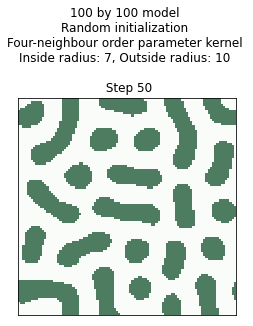

Button(description='Green Bubbles; (7, 10, 2)', style=ButtonStyle())

Button(description='Green Tubes; (7, 10, 2)', style=ButtonStyle())

Button(description='Mixed; (7, 10, 2)', style=ButtonStyle())

Button(description='White Bubbles; (7, 10, 2)', style=ButtonStyle())

Button(description='White Tubes; (7, 10, 2)', style=ButtonStyle())

Button(description='Error; (7, 10, 2)', style=ButtonStyle())

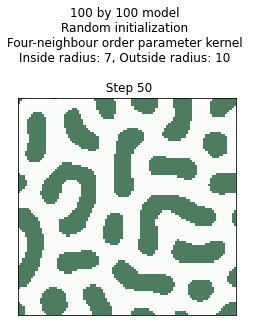

Button(description='Green Bubbles; (7, 10, 3)', style=ButtonStyle())

Button(description='Green Tubes; (7, 10, 3)', style=ButtonStyle())

Button(description='Mixed; (7, 10, 3)', style=ButtonStyle())

Button(description='White Bubbles; (7, 10, 3)', style=ButtonStyle())

Button(description='White Tubes; (7, 10, 3)', style=ButtonStyle())

Button(description='Error; (7, 10, 3)', style=ButtonStyle())

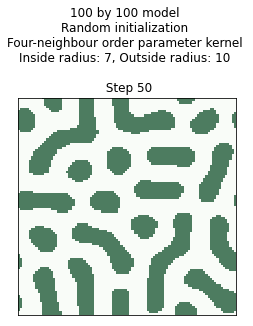

Button(description='Green Bubbles; (7, 10, 4)', style=ButtonStyle())

Button(description='Green Tubes; (7, 10, 4)', style=ButtonStyle())

Button(description='Mixed; (7, 10, 4)', style=ButtonStyle())

Button(description='White Bubbles; (7, 10, 4)', style=ButtonStyle())

Button(description='White Tubes; (7, 10, 4)', style=ButtonStyle())

Button(description='Error; (7, 10, 4)', style=ButtonStyle())

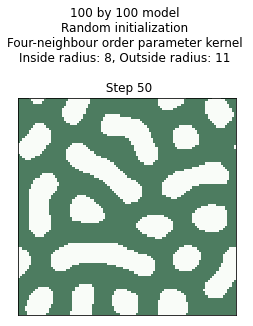

Button(description='Green Bubbles; (8, 11, 0)', style=ButtonStyle())

Button(description='Green Tubes; (8, 11, 0)', style=ButtonStyle())

Button(description='Mixed; (8, 11, 0)', style=ButtonStyle())

Button(description='White Bubbles; (8, 11, 0)', style=ButtonStyle())

Button(description='White Tubes; (8, 11, 0)', style=ButtonStyle())

Button(description='Error; (8, 11, 0)', style=ButtonStyle())

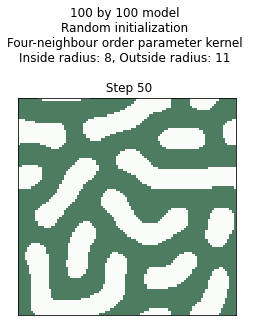

Button(description='Green Bubbles; (8, 11, 1)', style=ButtonStyle())

Button(description='Green Tubes; (8, 11, 1)', style=ButtonStyle())

Button(description='Mixed; (8, 11, 1)', style=ButtonStyle())

Button(description='White Bubbles; (8, 11, 1)', style=ButtonStyle())

Button(description='White Tubes; (8, 11, 1)', style=ButtonStyle())

Button(description='Error; (8, 11, 1)', style=ButtonStyle())

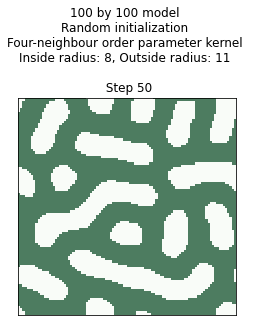

Button(description='Green Bubbles; (8, 11, 2)', style=ButtonStyle())

Button(description='Green Tubes; (8, 11, 2)', style=ButtonStyle())

Button(description='Mixed; (8, 11, 2)', style=ButtonStyle())

Button(description='White Bubbles; (8, 11, 2)', style=ButtonStyle())

Button(description='White Tubes; (8, 11, 2)', style=ButtonStyle())

Button(description='Error; (8, 11, 2)', style=ButtonStyle())

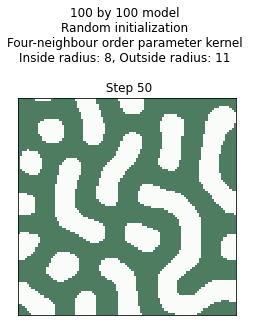

Button(description='Green Bubbles; (8, 11, 3)', style=ButtonStyle())

Button(description='Green Tubes; (8, 11, 3)', style=ButtonStyle())

Button(description='Mixed; (8, 11, 3)', style=ButtonStyle())

Button(description='White Bubbles; (8, 11, 3)', style=ButtonStyle())

Button(description='White Tubes; (8, 11, 3)', style=ButtonStyle())

Button(description='Error; (8, 11, 3)', style=ButtonStyle())

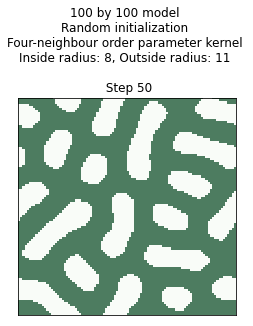

Button(description='Green Bubbles; (8, 11, 4)', style=ButtonStyle())

Button(description='Green Tubes; (8, 11, 4)', style=ButtonStyle())

Button(description='Mixed; (8, 11, 4)', style=ButtonStyle())

Button(description='White Bubbles; (8, 11, 4)', style=ButtonStyle())

Button(description='White Tubes; (8, 11, 4)', style=ButtonStyle())

Button(description='Error; (8, 11, 4)', style=ButtonStyle())

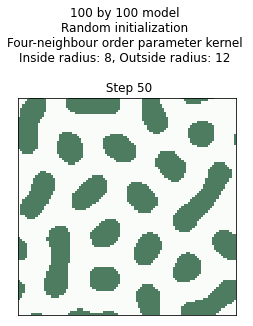

Button(description='Green Bubbles; (8, 12, 0)', style=ButtonStyle())

Button(description='Green Tubes; (8, 12, 0)', style=ButtonStyle())

Button(description='Mixed; (8, 12, 0)', style=ButtonStyle())

Button(description='White Bubbles; (8, 12, 0)', style=ButtonStyle())

Button(description='White Tubes; (8, 12, 0)', style=ButtonStyle())

Button(description='Error; (8, 12, 0)', style=ButtonStyle())

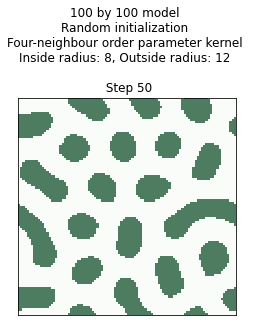

Button(description='Green Bubbles; (8, 12, 1)', style=ButtonStyle())

Button(description='Green Tubes; (8, 12, 1)', style=ButtonStyle())

Button(description='Mixed; (8, 12, 1)', style=ButtonStyle())

Button(description='White Bubbles; (8, 12, 1)', style=ButtonStyle())

Button(description='White Tubes; (8, 12, 1)', style=ButtonStyle())

Button(description='Error; (8, 12, 1)', style=ButtonStyle())

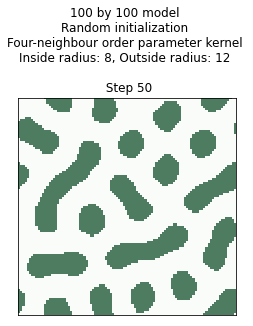

Button(description='Green Bubbles; (8, 12, 2)', style=ButtonStyle())

Button(description='Green Tubes; (8, 12, 2)', style=ButtonStyle())

Button(description='Mixed; (8, 12, 2)', style=ButtonStyle())

Button(description='White Bubbles; (8, 12, 2)', style=ButtonStyle())

Button(description='White Tubes; (8, 12, 2)', style=ButtonStyle())

Button(description='Error; (8, 12, 2)', style=ButtonStyle())

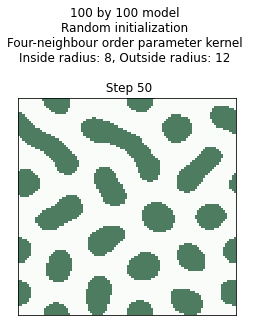

Button(description='Green Bubbles; (8, 12, 3)', style=ButtonStyle())

Button(description='Green Tubes; (8, 12, 3)', style=ButtonStyle())

Button(description='Mixed; (8, 12, 3)', style=ButtonStyle())

Button(description='White Bubbles; (8, 12, 3)', style=ButtonStyle())

Button(description='White Tubes; (8, 12, 3)', style=ButtonStyle())

Button(description='Error; (8, 12, 3)', style=ButtonStyle())

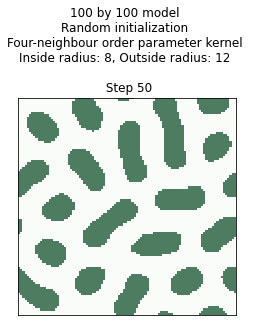

Button(description='Green Bubbles; (8, 12, 4)', style=ButtonStyle())

Button(description='Green Tubes; (8, 12, 4)', style=ButtonStyle())

Button(description='Mixed; (8, 12, 4)', style=ButtonStyle())

Button(description='White Bubbles; (8, 12, 4)', style=ButtonStyle())

Button(description='White Tubes; (8, 12, 4)', style=ButtonStyle())

Button(description='Error; (8, 12, 4)', style=ButtonStyle())

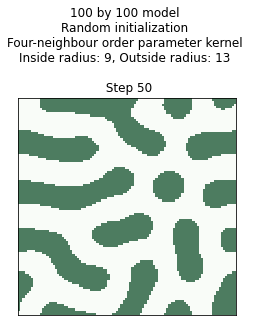

Button(description='Green Bubbles; (9, 13, 0)', style=ButtonStyle())

Button(description='Green Tubes; (9, 13, 0)', style=ButtonStyle())

Button(description='Mixed; (9, 13, 0)', style=ButtonStyle())

Button(description='White Bubbles; (9, 13, 0)', style=ButtonStyle())

Button(description='White Tubes; (9, 13, 0)', style=ButtonStyle())

Button(description='Error; (9, 13, 0)', style=ButtonStyle())

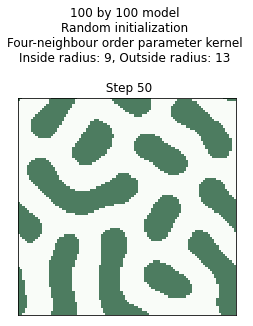

Button(description='Green Bubbles; (9, 13, 1)', style=ButtonStyle())

Button(description='Green Tubes; (9, 13, 1)', style=ButtonStyle())

Button(description='Mixed; (9, 13, 1)', style=ButtonStyle())

Button(description='White Bubbles; (9, 13, 1)', style=ButtonStyle())

Button(description='White Tubes; (9, 13, 1)', style=ButtonStyle())

Button(description='Error; (9, 13, 1)', style=ButtonStyle())

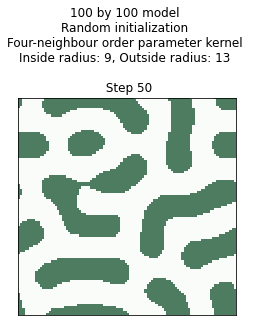

Button(description='Green Bubbles; (9, 13, 2)', style=ButtonStyle())

Button(description='Green Tubes; (9, 13, 2)', style=ButtonStyle())

Button(description='Mixed; (9, 13, 2)', style=ButtonStyle())

Button(description='White Bubbles; (9, 13, 2)', style=ButtonStyle())

Button(description='White Tubes; (9, 13, 2)', style=ButtonStyle())

Button(description='Error; (9, 13, 2)', style=ButtonStyle())

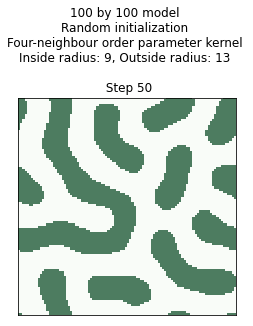

Button(description='Green Bubbles; (9, 13, 3)', style=ButtonStyle())

Button(description='Green Tubes; (9, 13, 3)', style=ButtonStyle())

Button(description='Mixed; (9, 13, 3)', style=ButtonStyle())

Button(description='White Bubbles; (9, 13, 3)', style=ButtonStyle())

Button(description='White Tubes; (9, 13, 3)', style=ButtonStyle())

Button(description='Error; (9, 13, 3)', style=ButtonStyle())

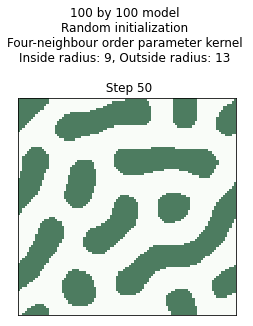

Button(description='Green Bubbles; (9, 13, 4)', style=ButtonStyle())

Button(description='Green Tubes; (9, 13, 4)', style=ButtonStyle())

Button(description='Mixed; (9, 13, 4)', style=ButtonStyle())

Button(description='White Bubbles; (9, 13, 4)', style=ButtonStyle())

Button(description='White Tubes; (9, 13, 4)', style=ButtonStyle())

Button(description='Error; (9, 13, 4)', style=ButtonStyle())

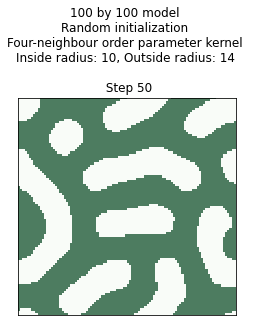

Button(description='Green Bubbles; (10, 14, 0)', style=ButtonStyle())

Button(description='Green Tubes; (10, 14, 0)', style=ButtonStyle())

Button(description='Mixed; (10, 14, 0)', style=ButtonStyle())

Button(description='White Bubbles; (10, 14, 0)', style=ButtonStyle())

Button(description='White Tubes; (10, 14, 0)', style=ButtonStyle())

Button(description='Error; (10, 14, 0)', style=ButtonStyle())

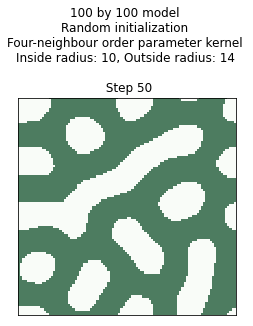

Button(description='Green Bubbles; (10, 14, 1)', style=ButtonStyle())

Button(description='Green Tubes; (10, 14, 1)', style=ButtonStyle())

Button(description='Mixed; (10, 14, 1)', style=ButtonStyle())

Button(description='White Bubbles; (10, 14, 1)', style=ButtonStyle())

Button(description='White Tubes; (10, 14, 1)', style=ButtonStyle())

Button(description='Error; (10, 14, 1)', style=ButtonStyle())

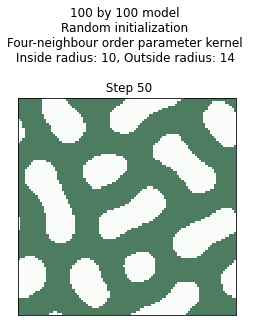

Button(description='Green Bubbles; (10, 14, 2)', style=ButtonStyle())

Button(description='Green Tubes; (10, 14, 2)', style=ButtonStyle())

Button(description='Mixed; (10, 14, 2)', style=ButtonStyle())

Button(description='White Bubbles; (10, 14, 2)', style=ButtonStyle())

Button(description='White Tubes; (10, 14, 2)', style=ButtonStyle())

Button(description='Error; (10, 14, 2)', style=ButtonStyle())

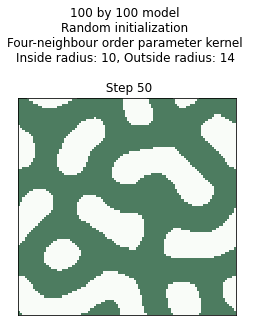

Button(description='Green Bubbles; (10, 14, 3)', style=ButtonStyle())

Button(description='Green Tubes; (10, 14, 3)', style=ButtonStyle())

Button(description='Mixed; (10, 14, 3)', style=ButtonStyle())

Button(description='White Bubbles; (10, 14, 3)', style=ButtonStyle())

Button(description='White Tubes; (10, 14, 3)', style=ButtonStyle())

Button(description='Error; (10, 14, 3)', style=ButtonStyle())

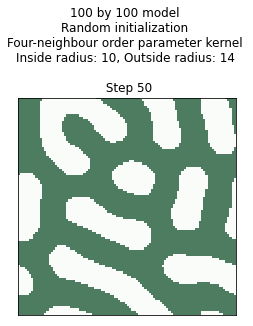

Button(description='Green Bubbles; (10, 14, 4)', style=ButtonStyle())

Button(description='Green Tubes; (10, 14, 4)', style=ButtonStyle())

Button(description='Mixed; (10, 14, 4)', style=ButtonStyle())

Button(description='White Bubbles; (10, 14, 4)', style=ButtonStyle())

Button(description='White Tubes; (10, 14, 4)', style=ButtonStyle())

Button(description='Error; (10, 14, 4)', style=ButtonStyle())

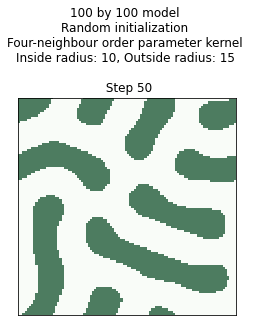

Button(description='Green Bubbles; (10, 15, 0)', style=ButtonStyle())

Button(description='Green Tubes; (10, 15, 0)', style=ButtonStyle())

Button(description='Mixed; (10, 15, 0)', style=ButtonStyle())

Button(description='White Bubbles; (10, 15, 0)', style=ButtonStyle())

Button(description='White Tubes; (10, 15, 0)', style=ButtonStyle())

Button(description='Error; (10, 15, 0)', style=ButtonStyle())

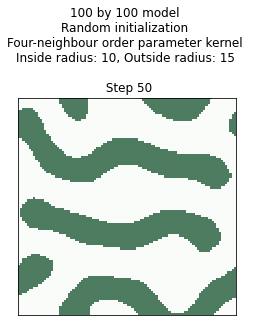

Button(description='Green Bubbles; (10, 15, 1)', style=ButtonStyle())

Button(description='Green Tubes; (10, 15, 1)', style=ButtonStyle())

Button(description='Mixed; (10, 15, 1)', style=ButtonStyle())

Button(description='White Bubbles; (10, 15, 1)', style=ButtonStyle())

Button(description='White Tubes; (10, 15, 1)', style=ButtonStyle())

Button(description='Error; (10, 15, 1)', style=ButtonStyle())

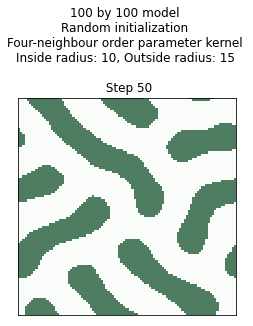

Button(description='Green Bubbles; (10, 15, 2)', style=ButtonStyle())

Button(description='Green Tubes; (10, 15, 2)', style=ButtonStyle())

Button(description='Mixed; (10, 15, 2)', style=ButtonStyle())

Button(description='White Bubbles; (10, 15, 2)', style=ButtonStyle())

Button(description='White Tubes; (10, 15, 2)', style=ButtonStyle())

Button(description='Error; (10, 15, 2)', style=ButtonStyle())

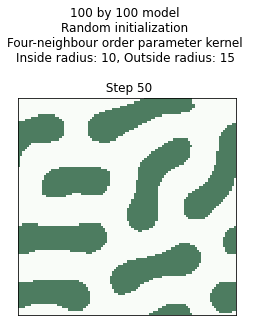

Button(description='Green Bubbles; (10, 15, 3)', style=ButtonStyle())

Button(description='Green Tubes; (10, 15, 3)', style=ButtonStyle())

Button(description='Mixed; (10, 15, 3)', style=ButtonStyle())

Button(description='White Bubbles; (10, 15, 3)', style=ButtonStyle())

Button(description='White Tubes; (10, 15, 3)', style=ButtonStyle())

Button(description='Error; (10, 15, 3)', style=ButtonStyle())

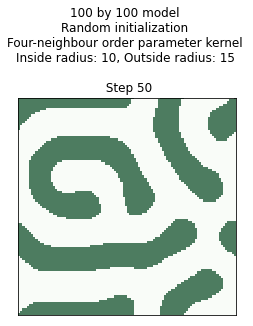

Button(description='Green Bubbles; (10, 15, 4)', style=ButtonStyle())

Button(description='Green Tubes; (10, 15, 4)', style=ButtonStyle())

Button(description='Mixed; (10, 15, 4)', style=ButtonStyle())

Button(description='White Bubbles; (10, 15, 4)', style=ButtonStyle())

Button(description='White Tubes; (10, 15, 4)', style=ButtonStyle())

Button(description='Error; (10, 15, 4)', style=ButtonStyle())

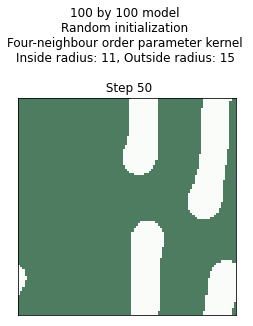

Button(description='Green Bubbles; (11, 15, 0)', style=ButtonStyle())

Button(description='Green Tubes; (11, 15, 0)', style=ButtonStyle())

Button(description='Mixed; (11, 15, 0)', style=ButtonStyle())

Button(description='White Bubbles; (11, 15, 0)', style=ButtonStyle())

Button(description='White Tubes; (11, 15, 0)', style=ButtonStyle())

Button(description='Error; (11, 15, 0)', style=ButtonStyle())

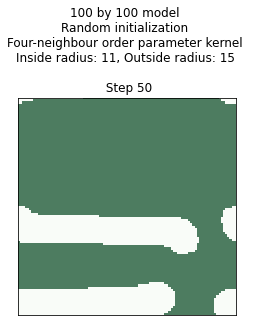

Button(description='Green Bubbles; (11, 15, 1)', style=ButtonStyle())

Button(description='Green Tubes; (11, 15, 1)', style=ButtonStyle())

Button(description='Mixed; (11, 15, 1)', style=ButtonStyle())

Button(description='White Bubbles; (11, 15, 1)', style=ButtonStyle())

Button(description='White Tubes; (11, 15, 1)', style=ButtonStyle())

Button(description='Error; (11, 15, 1)', style=ButtonStyle())

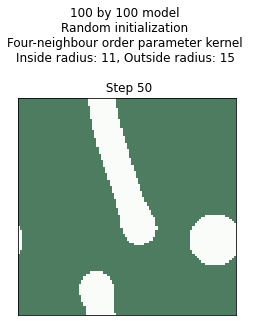

Button(description='Green Bubbles; (11, 15, 2)', style=ButtonStyle())

Button(description='Green Tubes; (11, 15, 2)', style=ButtonStyle())

Button(description='Mixed; (11, 15, 2)', style=ButtonStyle())

Button(description='White Bubbles; (11, 15, 2)', style=ButtonStyle())

Button(description='White Tubes; (11, 15, 2)', style=ButtonStyle())

Button(description='Error; (11, 15, 2)', style=ButtonStyle())

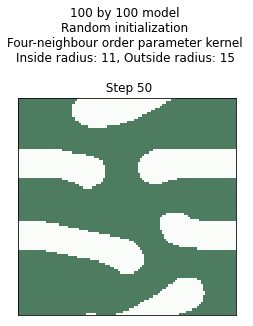

Button(description='Green Bubbles; (11, 15, 3)', style=ButtonStyle())

Button(description='Green Tubes; (11, 15, 3)', style=ButtonStyle())

Button(description='Mixed; (11, 15, 3)', style=ButtonStyle())

Button(description='White Bubbles; (11, 15, 3)', style=ButtonStyle())

Button(description='White Tubes; (11, 15, 3)', style=ButtonStyle())

Button(description='Error; (11, 15, 3)', style=ButtonStyle())

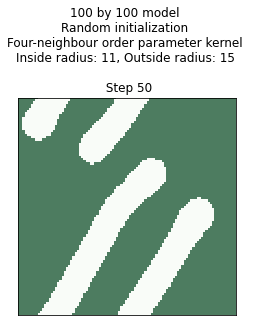

Button(description='Green Bubbles; (11, 15, 4)', style=ButtonStyle())

Button(description='Green Tubes; (11, 15, 4)', style=ButtonStyle())

Button(description='Mixed; (11, 15, 4)', style=ButtonStyle())

Button(description='White Bubbles; (11, 15, 4)', style=ButtonStyle())

Button(description='White Tubes; (11, 15, 4)', style=ButtonStyle())

Button(description='Error; (11, 15, 4)', style=ButtonStyle())

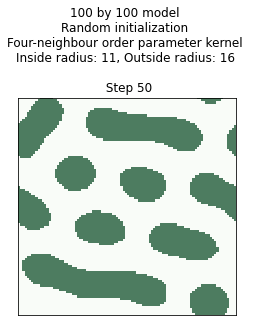

Button(description='Green Bubbles; (11, 16, 0)', style=ButtonStyle())

Button(description='Green Tubes; (11, 16, 0)', style=ButtonStyle())

Button(description='Mixed; (11, 16, 0)', style=ButtonStyle())

Button(description='White Bubbles; (11, 16, 0)', style=ButtonStyle())

Button(description='White Tubes; (11, 16, 0)', style=ButtonStyle())

Button(description='Error; (11, 16, 0)', style=ButtonStyle())

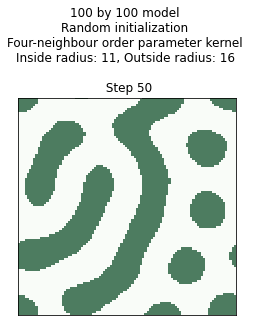

Button(description='Green Bubbles; (11, 16, 1)', style=ButtonStyle())

Button(description='Green Tubes; (11, 16, 1)', style=ButtonStyle())

Button(description='Mixed; (11, 16, 1)', style=ButtonStyle())

Button(description='White Bubbles; (11, 16, 1)', style=ButtonStyle())

Button(description='White Tubes; (11, 16, 1)', style=ButtonStyle())

Button(description='Error; (11, 16, 1)', style=ButtonStyle())

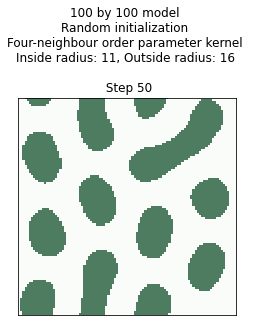

Button(description='Green Bubbles; (11, 16, 2)', style=ButtonStyle())

Button(description='Green Tubes; (11, 16, 2)', style=ButtonStyle())

Button(description='Mixed; (11, 16, 2)', style=ButtonStyle())

Button(description='White Bubbles; (11, 16, 2)', style=ButtonStyle())

Button(description='White Tubes; (11, 16, 2)', style=ButtonStyle())

Button(description='Error; (11, 16, 2)', style=ButtonStyle())

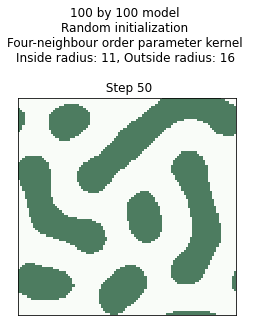

Button(description='Green Bubbles; (11, 16, 3)', style=ButtonStyle())

Button(description='Green Tubes; (11, 16, 3)', style=ButtonStyle())

Button(description='Mixed; (11, 16, 3)', style=ButtonStyle())

Button(description='White Bubbles; (11, 16, 3)', style=ButtonStyle())

Button(description='White Tubes; (11, 16, 3)', style=ButtonStyle())

Button(description='Error; (11, 16, 3)', style=ButtonStyle())

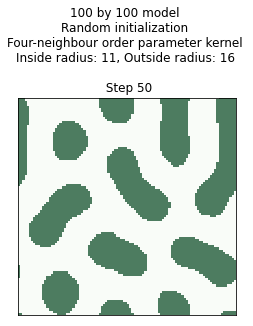

Button(description='Green Bubbles; (11, 16, 4)', style=ButtonStyle())

Button(description='Green Tubes; (11, 16, 4)', style=ButtonStyle())

Button(description='Mixed; (11, 16, 4)', style=ButtonStyle())

Button(description='White Bubbles; (11, 16, 4)', style=ButtonStyle())

Button(description='White Tubes; (11, 16, 4)', style=ButtonStyle())

Button(description='Error; (11, 16, 4)', style=ButtonStyle())

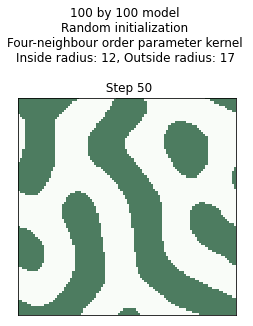

Button(description='Green Bubbles; (12, 17, 0)', style=ButtonStyle())

Button(description='Green Tubes; (12, 17, 0)', style=ButtonStyle())

Button(description='Mixed; (12, 17, 0)', style=ButtonStyle())

Button(description='White Bubbles; (12, 17, 0)', style=ButtonStyle())

Button(description='White Tubes; (12, 17, 0)', style=ButtonStyle())

Button(description='Error; (12, 17, 0)', style=ButtonStyle())

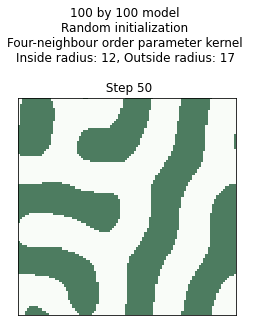

Button(description='Green Bubbles; (12, 17, 1)', style=ButtonStyle())

Button(description='Green Tubes; (12, 17, 1)', style=ButtonStyle())

Button(description='Mixed; (12, 17, 1)', style=ButtonStyle())

Button(description='White Bubbles; (12, 17, 1)', style=ButtonStyle())

Button(description='White Tubes; (12, 17, 1)', style=ButtonStyle())

Button(description='Error; (12, 17, 1)', style=ButtonStyle())

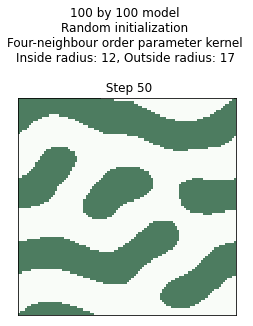

Button(description='Green Bubbles; (12, 17, 2)', style=ButtonStyle())

Button(description='Green Tubes; (12, 17, 2)', style=ButtonStyle())

Button(description='Mixed; (12, 17, 2)', style=ButtonStyle())

Button(description='White Bubbles; (12, 17, 2)', style=ButtonStyle())

Button(description='White Tubes; (12, 17, 2)', style=ButtonStyle())

Button(description='Error; (12, 17, 2)', style=ButtonStyle())

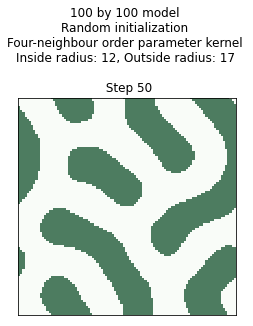

Button(description='Green Bubbles; (12, 17, 3)', style=ButtonStyle())

Button(description='Green Tubes; (12, 17, 3)', style=ButtonStyle())

Button(description='Mixed; (12, 17, 3)', style=ButtonStyle())

Button(description='White Bubbles; (12, 17, 3)', style=ButtonStyle())

Button(description='White Tubes; (12, 17, 3)', style=ButtonStyle())

Button(description='Error; (12, 17, 3)', style=ButtonStyle())

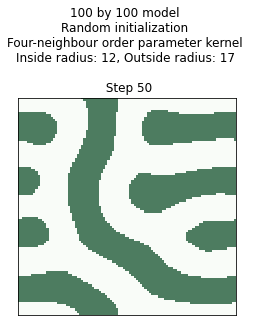

Button(description='Green Bubbles; (12, 17, 4)', style=ButtonStyle())

Button(description='Green Tubes; (12, 17, 4)', style=ButtonStyle())

Button(description='Mixed; (12, 17, 4)', style=ButtonStyle())

Button(description='White Bubbles; (12, 17, 4)', style=ButtonStyle())

Button(description='White Tubes; (12, 17, 4)', style=ButtonStyle())

Button(description='Error; (12, 17, 4)', style=ButtonStyle())

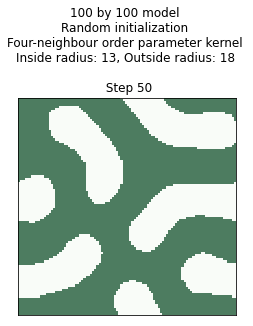

Button(description='Green Bubbles; (13, 18, 0)', style=ButtonStyle())

Button(description='Green Tubes; (13, 18, 0)', style=ButtonStyle())

Button(description='Mixed; (13, 18, 0)', style=ButtonStyle())

Button(description='White Bubbles; (13, 18, 0)', style=ButtonStyle())

Button(description='White Tubes; (13, 18, 0)', style=ButtonStyle())

Button(description='Error; (13, 18, 0)', style=ButtonStyle())

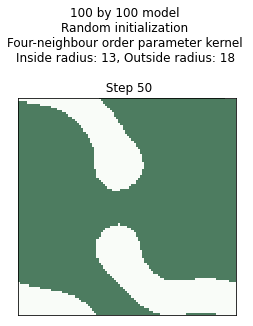

Button(description='Green Bubbles; (13, 18, 1)', style=ButtonStyle())

Button(description='Green Tubes; (13, 18, 1)', style=ButtonStyle())

Button(description='Mixed; (13, 18, 1)', style=ButtonStyle())

Button(description='White Bubbles; (13, 18, 1)', style=ButtonStyle())

Button(description='White Tubes; (13, 18, 1)', style=ButtonStyle())

Button(description='Error; (13, 18, 1)', style=ButtonStyle())

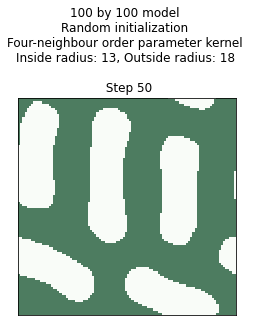

Button(description='Green Bubbles; (13, 18, 2)', style=ButtonStyle())

Button(description='Green Tubes; (13, 18, 2)', style=ButtonStyle())

Button(description='Mixed; (13, 18, 2)', style=ButtonStyle())

Button(description='White Bubbles; (13, 18, 2)', style=ButtonStyle())

Button(description='White Tubes; (13, 18, 2)', style=ButtonStyle())

Button(description='Error; (13, 18, 2)', style=ButtonStyle())

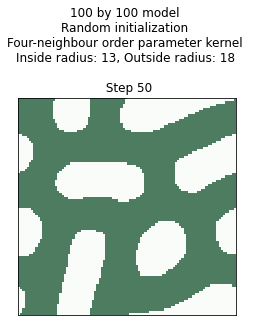

Button(description='Green Bubbles; (13, 18, 3)', style=ButtonStyle())

Button(description='Green Tubes; (13, 18, 3)', style=ButtonStyle())

Button(description='Mixed; (13, 18, 3)', style=ButtonStyle())

Button(description='White Bubbles; (13, 18, 3)', style=ButtonStyle())

Button(description='White Tubes; (13, 18, 3)', style=ButtonStyle())

Button(description='Error; (13, 18, 3)', style=ButtonStyle())

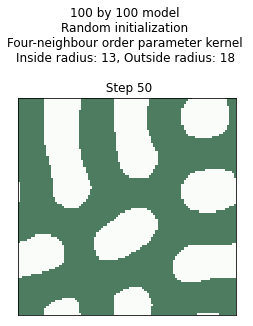

Button(description='Green Bubbles; (13, 18, 4)', style=ButtonStyle())

Button(description='Green Tubes; (13, 18, 4)', style=ButtonStyle())

Button(description='Mixed; (13, 18, 4)', style=ButtonStyle())

Button(description='White Bubbles; (13, 18, 4)', style=ButtonStyle())

Button(description='White Tubes; (13, 18, 4)', style=ButtonStyle())

Button(description='Error; (13, 18, 4)', style=ButtonStyle())

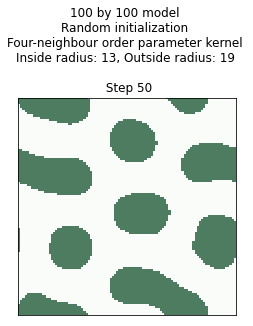

Button(description='Green Bubbles; (13, 19, 0)', style=ButtonStyle())

Button(description='Green Tubes; (13, 19, 0)', style=ButtonStyle())

Button(description='Mixed; (13, 19, 0)', style=ButtonStyle())

Button(description='White Bubbles; (13, 19, 0)', style=ButtonStyle())

Button(description='White Tubes; (13, 19, 0)', style=ButtonStyle())

Button(description='Error; (13, 19, 0)', style=ButtonStyle())

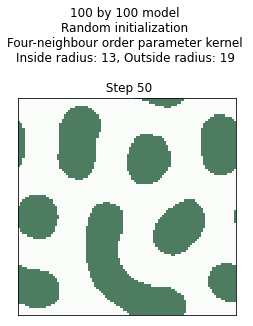

Button(description='Green Bubbles; (13, 19, 1)', style=ButtonStyle())

Button(description='Green Tubes; (13, 19, 1)', style=ButtonStyle())

Button(description='Mixed; (13, 19, 1)', style=ButtonStyle())

Button(description='White Bubbles; (13, 19, 1)', style=ButtonStyle())

Button(description='White Tubes; (13, 19, 1)', style=ButtonStyle())

Button(description='Error; (13, 19, 1)', style=ButtonStyle())

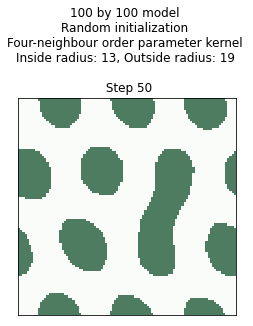

Button(description='Green Bubbles; (13, 19, 2)', style=ButtonStyle())

Button(description='Green Tubes; (13, 19, 2)', style=ButtonStyle())

Button(description='Mixed; (13, 19, 2)', style=ButtonStyle())

Button(description='White Bubbles; (13, 19, 2)', style=ButtonStyle())

Button(description='White Tubes; (13, 19, 2)', style=ButtonStyle())

Button(description='Error; (13, 19, 2)', style=ButtonStyle())

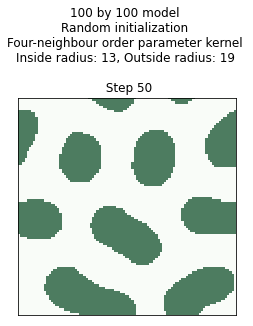

Button(description='Green Bubbles; (13, 19, 3)', style=ButtonStyle())

Button(description='Green Tubes; (13, 19, 3)', style=ButtonStyle())

Button(description='Mixed; (13, 19, 3)', style=ButtonStyle())

Button(description='White Bubbles; (13, 19, 3)', style=ButtonStyle())

Button(description='White Tubes; (13, 19, 3)', style=ButtonStyle())

Button(description='Error; (13, 19, 3)', style=ButtonStyle())

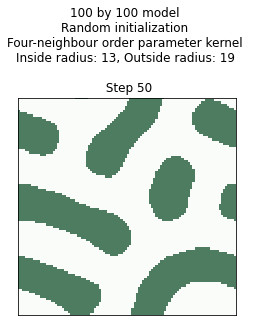

Button(description='Green Bubbles; (13, 19, 4)', style=ButtonStyle())

Button(description='Green Tubes; (13, 19, 4)', style=ButtonStyle())

Button(description='Mixed; (13, 19, 4)', style=ButtonStyle())

Button(description='White Bubbles; (13, 19, 4)', style=ButtonStyle())

Button(description='White Tubes; (13, 19, 4)', style=ButtonStyle())

Button(description='Error; (13, 19, 4)', style=ButtonStyle())

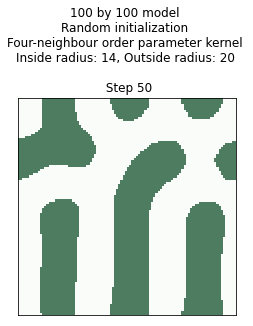

Button(description='Green Bubbles; (14, 20, 0)', style=ButtonStyle())

Button(description='Green Tubes; (14, 20, 0)', style=ButtonStyle())

Button(description='Mixed; (14, 20, 0)', style=ButtonStyle())

Button(description='White Bubbles; (14, 20, 0)', style=ButtonStyle())

Button(description='White Tubes; (14, 20, 0)', style=ButtonStyle())

Button(description='Error; (14, 20, 0)', style=ButtonStyle())

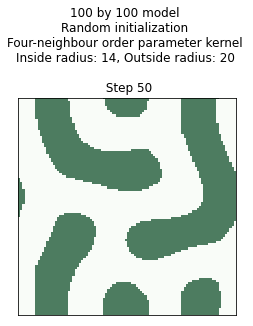

Button(description='Green Bubbles; (14, 20, 1)', style=ButtonStyle())

Button(description='Green Tubes; (14, 20, 1)', style=ButtonStyle())

Button(description='Mixed; (14, 20, 1)', style=ButtonStyle())

Button(description='White Bubbles; (14, 20, 1)', style=ButtonStyle())

Button(description='White Tubes; (14, 20, 1)', style=ButtonStyle())

Button(description='Error; (14, 20, 1)', style=ButtonStyle())

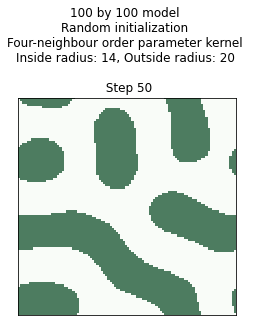

Button(description='Green Bubbles; (14, 20, 2)', style=ButtonStyle())

Button(description='Green Tubes; (14, 20, 2)', style=ButtonStyle())

Button(description='Mixed; (14, 20, 2)', style=ButtonStyle())

Button(description='White Bubbles; (14, 20, 2)', style=ButtonStyle())

Button(description='White Tubes; (14, 20, 2)', style=ButtonStyle())

Button(description='Error; (14, 20, 2)', style=ButtonStyle())

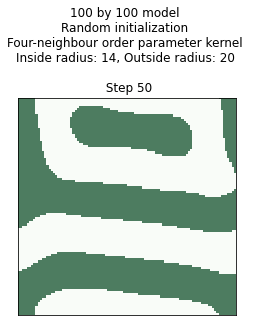

Button(description='Green Bubbles; (14, 20, 3)', style=ButtonStyle())

Button(description='Green Tubes; (14, 20, 3)', style=ButtonStyle())

Button(description='Mixed; (14, 20, 3)', style=ButtonStyle())

Button(description='White Bubbles; (14, 20, 3)', style=ButtonStyle())

Button(description='White Tubes; (14, 20, 3)', style=ButtonStyle())

Button(description='Error; (14, 20, 3)', style=ButtonStyle())

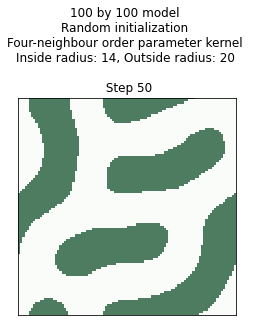

Button(description='Green Bubbles; (14, 20, 4)', style=ButtonStyle())

Button(description='Green Tubes; (14, 20, 4)', style=ButtonStyle())

Button(description='Mixed; (14, 20, 4)', style=ButtonStyle())

Button(description='White Bubbles; (14, 20, 4)', style=ButtonStyle())

Button(description='White Tubes; (14, 20, 4)', style=ButtonStyle())

Button(description='Error; (14, 20, 4)', style=ButtonStyle())

Button(button_style='warning', description='Submit', style=ButtonStyle())

{'Green Bubbles': [1.0, 0.9988, 0.9976, 0.995, 0.9964, 0.9424, 0.956, 0.939, 0.9408, 0.9554, 0.7602, 0.7584, 0.7608, 0.7622, 0.7598, 0.8352, 0.8318, 0.839, 0.8764, 0.876, 0.8742, 0.8736, 0.9216, 0.9218, 0.922], 'Green Tubes': [0.8296, 0.826, 0.8222, 0.8254, 0.827, 0.8862, 0.883, 0.8864, 0.8872, 0.8858, 0.902, 0.9088, 0.897, 0.904, 0.9024, 0.9118, 0.9148, 0.9124, 0.909, 0.9124, 0.92, 0.9298, 0.927, 0.926, 0.9304, 0.9248], 'Mixed': [0.8416, 0.8358, 0.8582, 0.854, 0.8548, 0.8546, 0.853, 0.8728, 0.8762, 0.9052, 0.9016, 0.9052, 0.9048, 0.906, 0.9224], 'White Tubes': [0.8758, 0.8744, 0.8726, 0.8698, 0.897, 0.8978, 0.895, 0.8986, 0.896, 0.959, 0.9576, 0.966, 0.936, 0.939, 0.924, 0.9582, 0.9266, 0.9246, 0.9264], 'White Bubbles': [0.894, 0.8978, 0.893, 0.8928, 0.8878]}


In [33]:
test_data = valid_parameters[0]

iterations = 5
button_dict = {}
orders = {
          'Green Bubbles': [],
          'Green Tubes': [],
          'Mixed': [],
          'White Tubes': [],
          'White Bubbles': []
        }

def clicked(arg):   
    string = arg.description.split('; ')[0]
    index = arg.description.split('; ')[1].replace('(', '').replace(')', '').split(',')
    
    arg.button_style = 'success'
    if 'Error' in arg.description:
        arg.button_style = 'danger'
    
    ri, ro, i = int(index[0]), int(index[1]), int(index[2])
    index = f'{(ri, ro)}'
    buttons = button_dict[index][i][0]
    order = button_dict[index][i][1]
    
    
    for button in buttons:
        button.disabled = True
        
    if not string == 'Error': 
        orders[string].append(order)
        

def submitted(arg):       
    print(orders)
    
    
for i in test_data:
    
    index = f'{(i[0], i[1])}'
    button_dict[index] = []
    
    for iteration in range(iterations):
        a = ReactionDiffusion(100, i[0], i[1])
        a.loop(50)
        a.draw()
        plt.show()

        identifier = (i[0], i[1], iteration)
        greenSpheres = widgets.Button(description = f'Green Bubbles; {identifier}')
        greenTubes = widgets.Button(description = f'Green Tubes; {identifier}')   
        mixed = widgets.Button(description = f'Mixed; {identifier}')  
        whiteTubes = widgets.Button(description = f'White Tubes; {identifier}')   
        whiteSpheres = widgets.Button(description = f'White Bubbles; {identifier}')  
        nothing = widgets.Button(description = f'Error; {identifier}')
        
        buttons = [greenSpheres, greenTubes, mixed, whiteSpheres, whiteTubes, nothing]
        button_dict[index].append((buttons, a.order_parameter))

        for button in buttons:
            button.on_click(clicked)
            display(button)

            
submit = widgets.Button(description = 'Submit', button_style='warning')
submit.on_click(submitted)
display(submit)

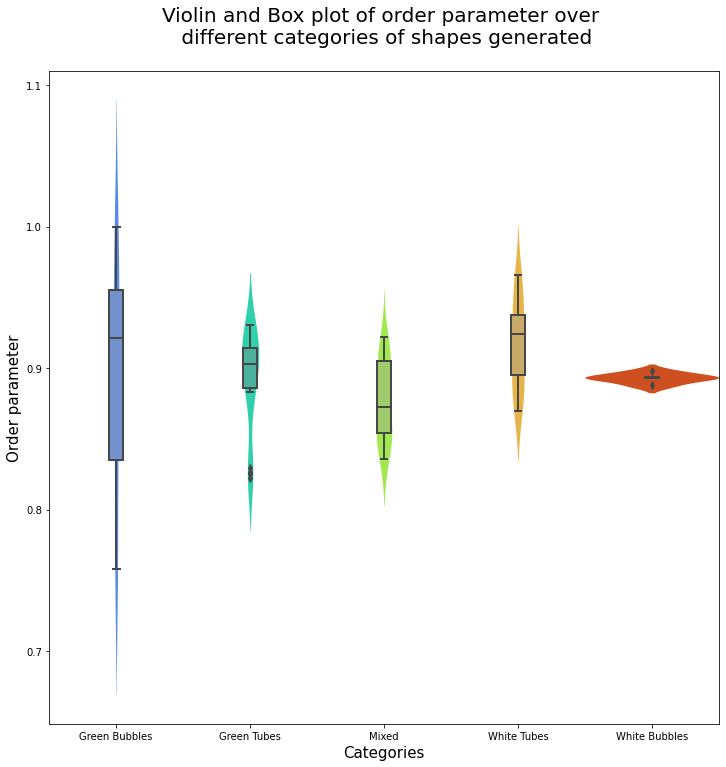

In [41]:
plotting2 = [i for i in orders.values()]

fig = plt.figure(figsize=(12, 12))
ax = sns.violinplot(data = plotting2, palette='turbo',
                    inner=None, linewidth=0, saturation=0.8, width=1)
sns.boxplot(data=plotting2, palette='turbo', width=0.1,
            boxprops={'zorder': 2}, ax=ax, saturation=0.5)


ax.set_xticklabels([i for i in areas.keys()], rotation=0, size=10)
ax.set_xlabel('Categories', size=15)
ax.set_ylabel('Order parameter', size=15)
ax.set_title("Violin and Box plot of order parameter over \n different categories of shapes generated\n", size=20)


plt.show()

### Plotting relative area

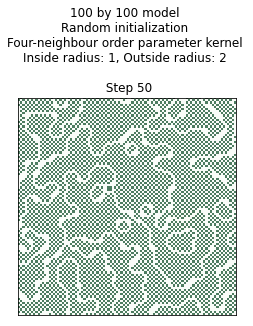

Button(description='Green Bubbles; (1, 2, 0)', style=ButtonStyle())

Button(description='Green Tubes; (1, 2, 0)', style=ButtonStyle())

Button(description='Mixed; (1, 2, 0)', style=ButtonStyle())

Button(description='White Bubbles; (1, 2, 0)', style=ButtonStyle())

Button(description='White Tubes; (1, 2, 0)', style=ButtonStyle())

Button(description='Error; (1, 2, 0)', style=ButtonStyle())

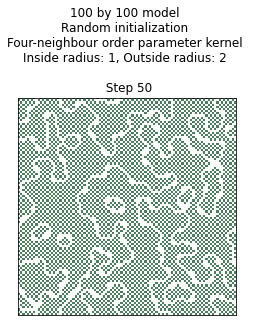

Button(description='Green Bubbles; (1, 2, 1)', style=ButtonStyle())

Button(description='Green Tubes; (1, 2, 1)', style=ButtonStyle())

Button(description='Mixed; (1, 2, 1)', style=ButtonStyle())

Button(description='White Bubbles; (1, 2, 1)', style=ButtonStyle())

Button(description='White Tubes; (1, 2, 1)', style=ButtonStyle())

Button(description='Error; (1, 2, 1)', style=ButtonStyle())

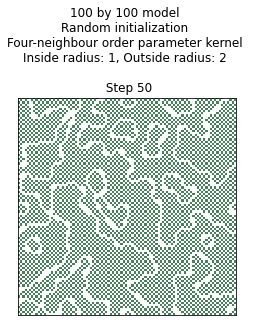

Button(description='Green Bubbles; (1, 2, 2)', style=ButtonStyle())

Button(description='Green Tubes; (1, 2, 2)', style=ButtonStyle())

Button(description='Mixed; (1, 2, 2)', style=ButtonStyle())

Button(description='White Bubbles; (1, 2, 2)', style=ButtonStyle())

Button(description='White Tubes; (1, 2, 2)', style=ButtonStyle())

Button(description='Error; (1, 2, 2)', style=ButtonStyle())

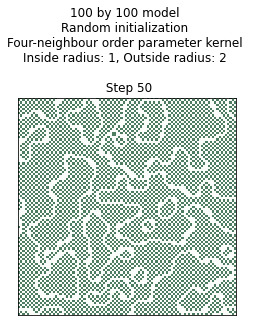

Button(description='Green Bubbles; (1, 2, 3)', style=ButtonStyle())

Button(description='Green Tubes; (1, 2, 3)', style=ButtonStyle())

Button(description='Mixed; (1, 2, 3)', style=ButtonStyle())

Button(description='White Bubbles; (1, 2, 3)', style=ButtonStyle())

Button(description='White Tubes; (1, 2, 3)', style=ButtonStyle())

Button(description='Error; (1, 2, 3)', style=ButtonStyle())

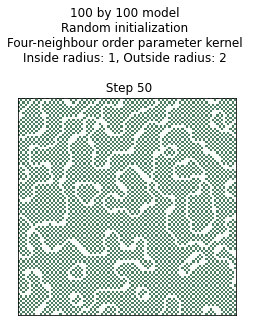

Button(description='Green Bubbles; (1, 2, 4)', style=ButtonStyle())

Button(description='Green Tubes; (1, 2, 4)', style=ButtonStyle())

Button(description='Mixed; (1, 2, 4)', style=ButtonStyle())

Button(description='White Bubbles; (1, 2, 4)', style=ButtonStyle())

Button(description='White Tubes; (1, 2, 4)', style=ButtonStyle())

Button(description='Error; (1, 2, 4)', style=ButtonStyle())

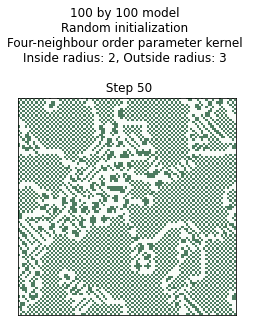

Button(description='Green Bubbles; (2, 3, 0)', style=ButtonStyle())

Button(description='Green Tubes; (2, 3, 0)', style=ButtonStyle())

Button(description='Mixed; (2, 3, 0)', style=ButtonStyle())

Button(description='White Bubbles; (2, 3, 0)', style=ButtonStyle())

Button(description='White Tubes; (2, 3, 0)', style=ButtonStyle())

Button(description='Error; (2, 3, 0)', style=ButtonStyle())

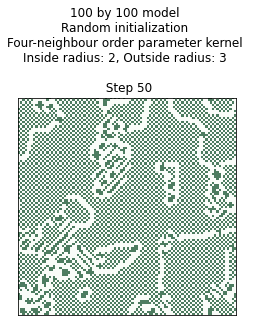

Button(description='Green Bubbles; (2, 3, 1)', style=ButtonStyle())

Button(description='Green Tubes; (2, 3, 1)', style=ButtonStyle())

Button(description='Mixed; (2, 3, 1)', style=ButtonStyle())

Button(description='White Bubbles; (2, 3, 1)', style=ButtonStyle())

Button(description='White Tubes; (2, 3, 1)', style=ButtonStyle())

Button(description='Error; (2, 3, 1)', style=ButtonStyle())

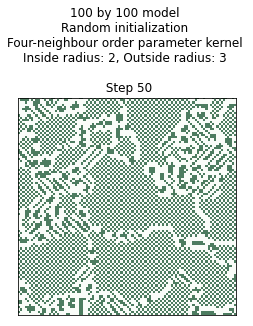

Button(description='Green Bubbles; (2, 3, 2)', style=ButtonStyle())

Button(description='Green Tubes; (2, 3, 2)', style=ButtonStyle())

Button(description='Mixed; (2, 3, 2)', style=ButtonStyle())

Button(description='White Bubbles; (2, 3, 2)', style=ButtonStyle())

Button(description='White Tubes; (2, 3, 2)', style=ButtonStyle())

Button(description='Error; (2, 3, 2)', style=ButtonStyle())

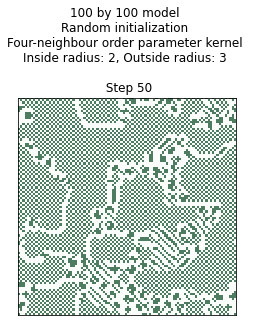

Button(description='Green Bubbles; (2, 3, 3)', style=ButtonStyle())

Button(description='Green Tubes; (2, 3, 3)', style=ButtonStyle())

Button(description='Mixed; (2, 3, 3)', style=ButtonStyle())

Button(description='White Bubbles; (2, 3, 3)', style=ButtonStyle())

Button(description='White Tubes; (2, 3, 3)', style=ButtonStyle())

Button(description='Error; (2, 3, 3)', style=ButtonStyle())

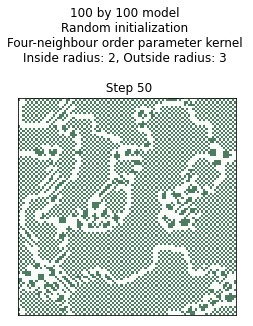

Button(description='Green Bubbles; (2, 3, 4)', style=ButtonStyle())

Button(description='Green Tubes; (2, 3, 4)', style=ButtonStyle())

Button(description='Mixed; (2, 3, 4)', style=ButtonStyle())

Button(description='White Bubbles; (2, 3, 4)', style=ButtonStyle())

Button(description='White Tubes; (2, 3, 4)', style=ButtonStyle())

Button(description='Error; (2, 3, 4)', style=ButtonStyle())

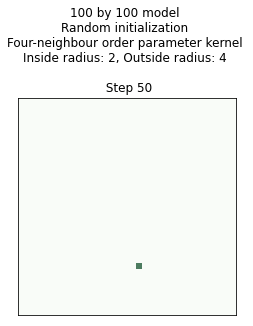

Button(description='Green Bubbles; (2, 4, 0)', style=ButtonStyle())

Button(description='Green Tubes; (2, 4, 0)', style=ButtonStyle())

Button(description='Mixed; (2, 4, 0)', style=ButtonStyle())

Button(description='White Bubbles; (2, 4, 0)', style=ButtonStyle())

Button(description='White Tubes; (2, 4, 0)', style=ButtonStyle())

Button(description='Error; (2, 4, 0)', style=ButtonStyle())

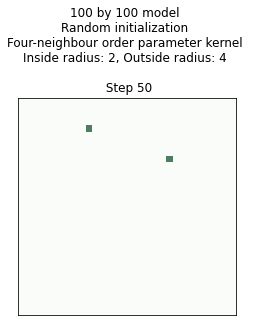

Button(description='Green Bubbles; (2, 4, 1)', style=ButtonStyle())

Button(description='Green Tubes; (2, 4, 1)', style=ButtonStyle())

Button(description='Mixed; (2, 4, 1)', style=ButtonStyle())

Button(description='White Bubbles; (2, 4, 1)', style=ButtonStyle())

Button(description='White Tubes; (2, 4, 1)', style=ButtonStyle())

Button(description='Error; (2, 4, 1)', style=ButtonStyle())

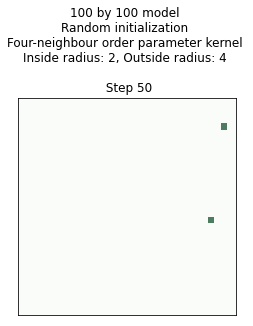

Button(description='Green Bubbles; (2, 4, 2)', style=ButtonStyle())

Button(description='Green Tubes; (2, 4, 2)', style=ButtonStyle())

Button(description='Mixed; (2, 4, 2)', style=ButtonStyle())

Button(description='White Bubbles; (2, 4, 2)', style=ButtonStyle())

Button(description='White Tubes; (2, 4, 2)', style=ButtonStyle())

Button(description='Error; (2, 4, 2)', style=ButtonStyle())

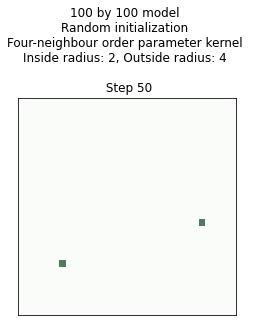

Button(description='Green Bubbles; (2, 4, 3)', style=ButtonStyle())

Button(description='Green Tubes; (2, 4, 3)', style=ButtonStyle())

Button(description='Mixed; (2, 4, 3)', style=ButtonStyle())

Button(description='White Bubbles; (2, 4, 3)', style=ButtonStyle())

Button(description='White Tubes; (2, 4, 3)', style=ButtonStyle())

Button(description='Error; (2, 4, 3)', style=ButtonStyle())

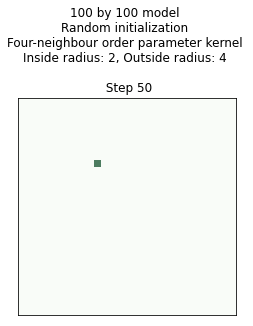

Button(description='Green Bubbles; (2, 4, 4)', style=ButtonStyle())

Button(description='Green Tubes; (2, 4, 4)', style=ButtonStyle())

Button(description='Mixed; (2, 4, 4)', style=ButtonStyle())

Button(description='White Bubbles; (2, 4, 4)', style=ButtonStyle())

Button(description='White Tubes; (2, 4, 4)', style=ButtonStyle())

Button(description='Error; (2, 4, 4)', style=ButtonStyle())

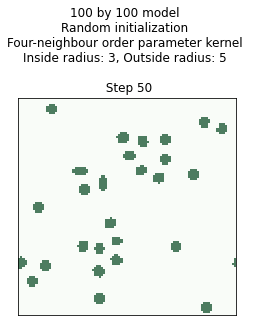

Button(description='Green Bubbles; (3, 5, 0)', style=ButtonStyle())

Button(description='Green Tubes; (3, 5, 0)', style=ButtonStyle())

Button(description='Mixed; (3, 5, 0)', style=ButtonStyle())

Button(description='White Bubbles; (3, 5, 0)', style=ButtonStyle())

Button(description='White Tubes; (3, 5, 0)', style=ButtonStyle())

Button(description='Error; (3, 5, 0)', style=ButtonStyle())

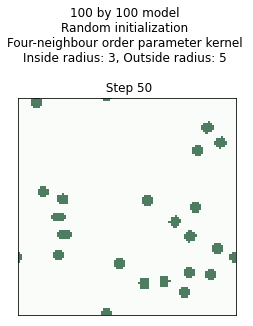

Button(description='Green Bubbles; (3, 5, 1)', style=ButtonStyle())

Button(description='Green Tubes; (3, 5, 1)', style=ButtonStyle())

Button(description='Mixed; (3, 5, 1)', style=ButtonStyle())

Button(description='White Bubbles; (3, 5, 1)', style=ButtonStyle())

Button(description='White Tubes; (3, 5, 1)', style=ButtonStyle())

Button(description='Error; (3, 5, 1)', style=ButtonStyle())

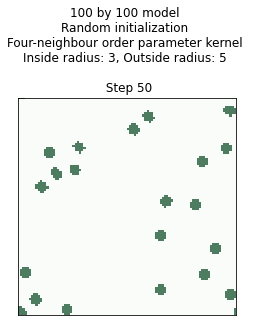

Button(description='Green Bubbles; (3, 5, 2)', style=ButtonStyle())

Button(description='Green Tubes; (3, 5, 2)', style=ButtonStyle())

Button(description='Mixed; (3, 5, 2)', style=ButtonStyle())

Button(description='White Bubbles; (3, 5, 2)', style=ButtonStyle())

Button(description='White Tubes; (3, 5, 2)', style=ButtonStyle())

Button(description='Error; (3, 5, 2)', style=ButtonStyle())

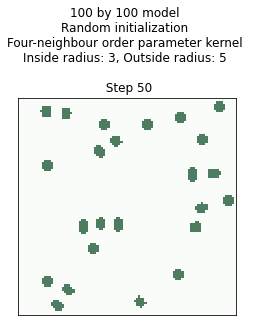

Button(description='Green Bubbles; (3, 5, 3)', style=ButtonStyle())

Button(description='Green Tubes; (3, 5, 3)', style=ButtonStyle())

Button(description='Mixed; (3, 5, 3)', style=ButtonStyle())

Button(description='White Bubbles; (3, 5, 3)', style=ButtonStyle())

Button(description='White Tubes; (3, 5, 3)', style=ButtonStyle())

Button(description='Error; (3, 5, 3)', style=ButtonStyle())

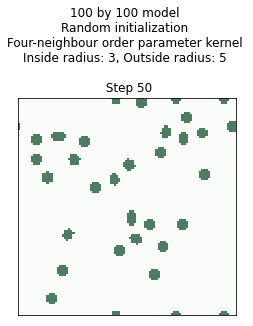

Button(description='Green Bubbles; (3, 5, 4)', style=ButtonStyle())

Button(description='Green Tubes; (3, 5, 4)', style=ButtonStyle())

Button(description='Mixed; (3, 5, 4)', style=ButtonStyle())

Button(description='White Bubbles; (3, 5, 4)', style=ButtonStyle())

Button(description='White Tubes; (3, 5, 4)', style=ButtonStyle())

Button(description='Error; (3, 5, 4)', style=ButtonStyle())

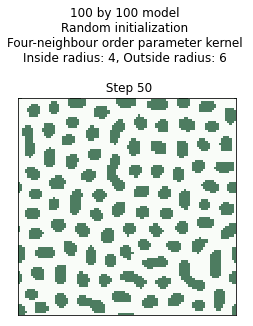

Button(description='Green Bubbles; (4, 6, 0)', style=ButtonStyle())

Button(description='Green Tubes; (4, 6, 0)', style=ButtonStyle())

Button(description='Mixed; (4, 6, 0)', style=ButtonStyle())

Button(description='White Bubbles; (4, 6, 0)', style=ButtonStyle())

Button(description='White Tubes; (4, 6, 0)', style=ButtonStyle())

Button(description='Error; (4, 6, 0)', style=ButtonStyle())

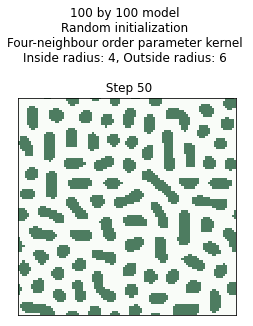

Button(description='Green Bubbles; (4, 6, 1)', style=ButtonStyle())

Button(description='Green Tubes; (4, 6, 1)', style=ButtonStyle())

Button(description='Mixed; (4, 6, 1)', style=ButtonStyle())

Button(description='White Bubbles; (4, 6, 1)', style=ButtonStyle())

Button(description='White Tubes; (4, 6, 1)', style=ButtonStyle())

Button(description='Error; (4, 6, 1)', style=ButtonStyle())

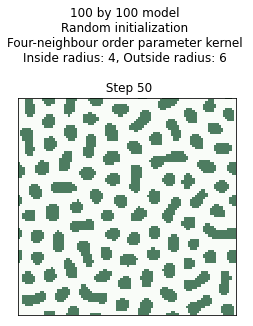

Button(description='Green Bubbles; (4, 6, 2)', style=ButtonStyle())

Button(description='Green Tubes; (4, 6, 2)', style=ButtonStyle())

Button(description='Mixed; (4, 6, 2)', style=ButtonStyle())

Button(description='White Bubbles; (4, 6, 2)', style=ButtonStyle())

Button(description='White Tubes; (4, 6, 2)', style=ButtonStyle())

Button(description='Error; (4, 6, 2)', style=ButtonStyle())

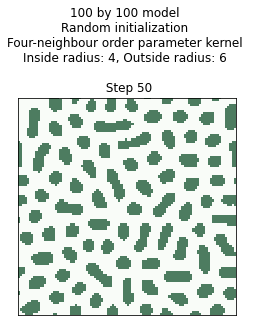

Button(description='Green Bubbles; (4, 6, 3)', style=ButtonStyle())

Button(description='Green Tubes; (4, 6, 3)', style=ButtonStyle())

Button(description='Mixed; (4, 6, 3)', style=ButtonStyle())

Button(description='White Bubbles; (4, 6, 3)', style=ButtonStyle())

Button(description='White Tubes; (4, 6, 3)', style=ButtonStyle())

Button(description='Error; (4, 6, 3)', style=ButtonStyle())

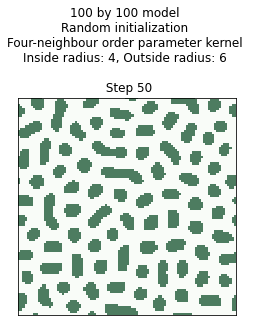

Button(description='Green Bubbles; (4, 6, 4)', style=ButtonStyle())

Button(description='Green Tubes; (4, 6, 4)', style=ButtonStyle())

Button(description='Mixed; (4, 6, 4)', style=ButtonStyle())

Button(description='White Bubbles; (4, 6, 4)', style=ButtonStyle())

Button(description='White Tubes; (4, 6, 4)', style=ButtonStyle())

Button(description='Error; (4, 6, 4)', style=ButtonStyle())

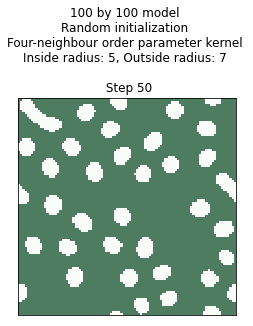

Button(description='Green Bubbles; (5, 7, 0)', style=ButtonStyle())

Button(description='Green Tubes; (5, 7, 0)', style=ButtonStyle())

Button(description='Mixed; (5, 7, 0)', style=ButtonStyle())

Button(description='White Bubbles; (5, 7, 0)', style=ButtonStyle())

Button(description='White Tubes; (5, 7, 0)', style=ButtonStyle())

Button(description='Error; (5, 7, 0)', style=ButtonStyle())

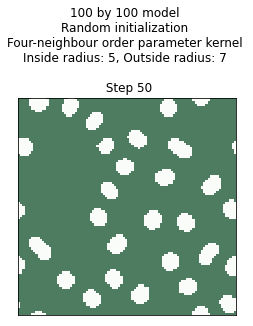

Button(description='Green Bubbles; (5, 7, 1)', style=ButtonStyle())

Button(description='Green Tubes; (5, 7, 1)', style=ButtonStyle())

Button(description='Mixed; (5, 7, 1)', style=ButtonStyle())

Button(description='White Bubbles; (5, 7, 1)', style=ButtonStyle())

Button(description='White Tubes; (5, 7, 1)', style=ButtonStyle())

Button(description='Error; (5, 7, 1)', style=ButtonStyle())

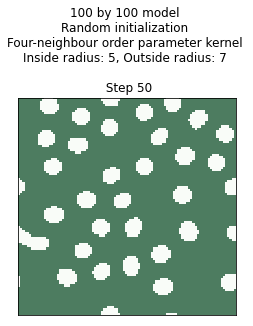

Button(description='Green Bubbles; (5, 7, 2)', style=ButtonStyle())

Button(description='Green Tubes; (5, 7, 2)', style=ButtonStyle())

Button(description='Mixed; (5, 7, 2)', style=ButtonStyle())

Button(description='White Bubbles; (5, 7, 2)', style=ButtonStyle())

Button(description='White Tubes; (5, 7, 2)', style=ButtonStyle())

Button(description='Error; (5, 7, 2)', style=ButtonStyle())

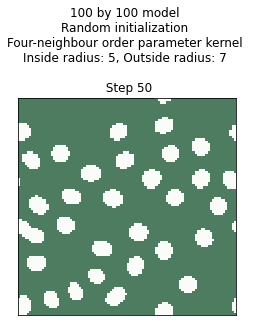

Button(description='Green Bubbles; (5, 7, 3)', style=ButtonStyle())

Button(description='Green Tubes; (5, 7, 3)', style=ButtonStyle())

Button(description='Mixed; (5, 7, 3)', style=ButtonStyle())

Button(description='White Bubbles; (5, 7, 3)', style=ButtonStyle())

Button(description='White Tubes; (5, 7, 3)', style=ButtonStyle())

Button(description='Error; (5, 7, 3)', style=ButtonStyle())

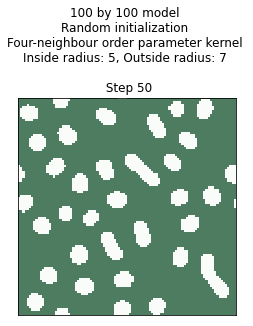

Button(description='Green Bubbles; (5, 7, 4)', style=ButtonStyle())

Button(description='Green Tubes; (5, 7, 4)', style=ButtonStyle())

Button(description='Mixed; (5, 7, 4)', style=ButtonStyle())

Button(description='White Bubbles; (5, 7, 4)', style=ButtonStyle())

Button(description='White Tubes; (5, 7, 4)', style=ButtonStyle())

Button(description='Error; (5, 7, 4)', style=ButtonStyle())

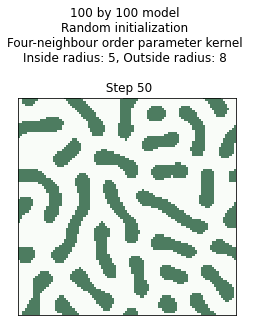

Button(description='Green Bubbles; (5, 8, 0)', style=ButtonStyle())

Button(description='Green Tubes; (5, 8, 0)', style=ButtonStyle())

Button(description='Mixed; (5, 8, 0)', style=ButtonStyle())

Button(description='White Bubbles; (5, 8, 0)', style=ButtonStyle())

Button(description='White Tubes; (5, 8, 0)', style=ButtonStyle())

Button(description='Error; (5, 8, 0)', style=ButtonStyle())

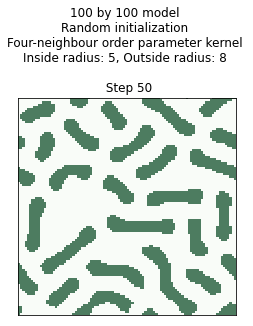

Button(description='Green Bubbles; (5, 8, 1)', style=ButtonStyle())

Button(description='Green Tubes; (5, 8, 1)', style=ButtonStyle())

Button(description='Mixed; (5, 8, 1)', style=ButtonStyle())

Button(description='White Bubbles; (5, 8, 1)', style=ButtonStyle())

Button(description='White Tubes; (5, 8, 1)', style=ButtonStyle())

Button(description='Error; (5, 8, 1)', style=ButtonStyle())

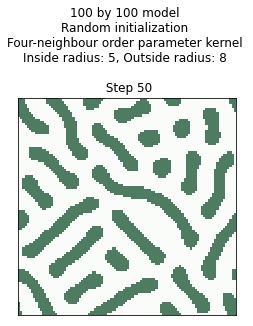

Button(description='Green Bubbles; (5, 8, 2)', style=ButtonStyle())

Button(description='Green Tubes; (5, 8, 2)', style=ButtonStyle())

Button(description='Mixed; (5, 8, 2)', style=ButtonStyle())

Button(description='White Bubbles; (5, 8, 2)', style=ButtonStyle())

Button(description='White Tubes; (5, 8, 2)', style=ButtonStyle())

Button(description='Error; (5, 8, 2)', style=ButtonStyle())

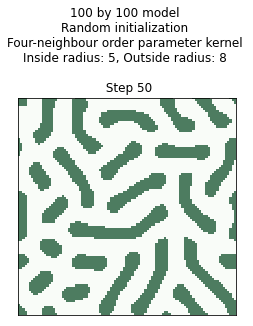

Button(description='Green Bubbles; (5, 8, 3)', style=ButtonStyle())

Button(description='Green Tubes; (5, 8, 3)', style=ButtonStyle())

Button(description='Mixed; (5, 8, 3)', style=ButtonStyle())

Button(description='White Bubbles; (5, 8, 3)', style=ButtonStyle())

Button(description='White Tubes; (5, 8, 3)', style=ButtonStyle())

Button(description='Error; (5, 8, 3)', style=ButtonStyle())

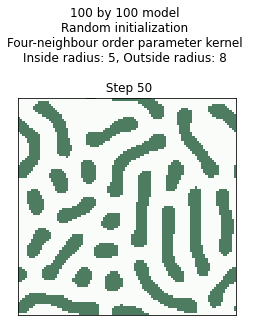

Button(description='Green Bubbles; (5, 8, 4)', style=ButtonStyle())

Button(description='Green Tubes; (5, 8, 4)', style=ButtonStyle())

Button(description='Mixed; (5, 8, 4)', style=ButtonStyle())

Button(description='White Bubbles; (5, 8, 4)', style=ButtonStyle())

Button(description='White Tubes; (5, 8, 4)', style=ButtonStyle())

Button(description='Error; (5, 8, 4)', style=ButtonStyle())

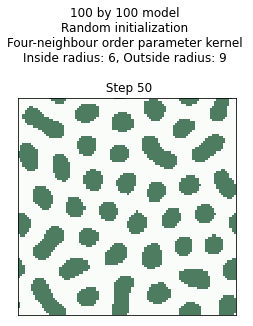

Button(description='Green Bubbles; (6, 9, 0)', style=ButtonStyle())

Button(description='Green Tubes; (6, 9, 0)', style=ButtonStyle())

Button(description='Mixed; (6, 9, 0)', style=ButtonStyle())

Button(description='White Bubbles; (6, 9, 0)', style=ButtonStyle())

Button(description='White Tubes; (6, 9, 0)', style=ButtonStyle())

Button(description='Error; (6, 9, 0)', style=ButtonStyle())

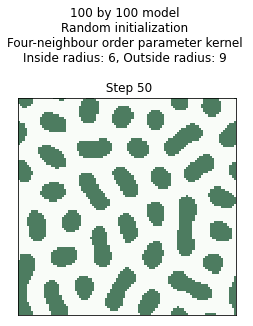

Button(description='Green Bubbles; (6, 9, 1)', style=ButtonStyle())

Button(description='Green Tubes; (6, 9, 1)', style=ButtonStyle())

Button(description='Mixed; (6, 9, 1)', style=ButtonStyle())

Button(description='White Bubbles; (6, 9, 1)', style=ButtonStyle())

Button(description='White Tubes; (6, 9, 1)', style=ButtonStyle())

Button(description='Error; (6, 9, 1)', style=ButtonStyle())

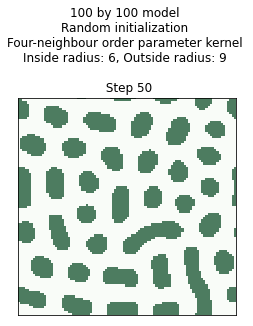

Button(description='Green Bubbles; (6, 9, 2)', style=ButtonStyle())

Button(description='Green Tubes; (6, 9, 2)', style=ButtonStyle())

Button(description='Mixed; (6, 9, 2)', style=ButtonStyle())

Button(description='White Bubbles; (6, 9, 2)', style=ButtonStyle())

Button(description='White Tubes; (6, 9, 2)', style=ButtonStyle())

Button(description='Error; (6, 9, 2)', style=ButtonStyle())

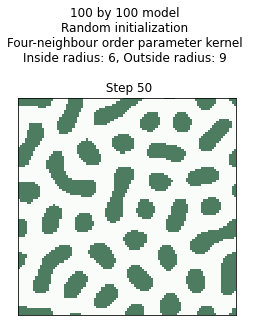

Button(description='Green Bubbles; (6, 9, 3)', style=ButtonStyle())

Button(description='Green Tubes; (6, 9, 3)', style=ButtonStyle())

Button(description='Mixed; (6, 9, 3)', style=ButtonStyle())

Button(description='White Bubbles; (6, 9, 3)', style=ButtonStyle())

Button(description='White Tubes; (6, 9, 3)', style=ButtonStyle())

Button(description='Error; (6, 9, 3)', style=ButtonStyle())

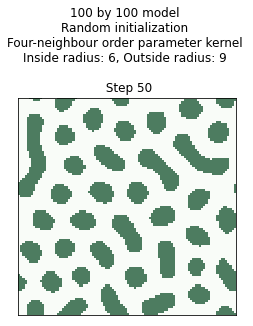

Button(description='Green Bubbles; (6, 9, 4)', style=ButtonStyle())

Button(description='Green Tubes; (6, 9, 4)', style=ButtonStyle())

Button(description='Mixed; (6, 9, 4)', style=ButtonStyle())

Button(description='White Bubbles; (6, 9, 4)', style=ButtonStyle())

Button(description='White Tubes; (6, 9, 4)', style=ButtonStyle())

Button(description='Error; (6, 9, 4)', style=ButtonStyle())

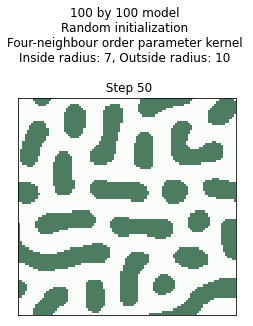

Button(description='Green Bubbles; (7, 10, 0)', style=ButtonStyle())

Button(description='Green Tubes; (7, 10, 0)', style=ButtonStyle())

Button(description='Mixed; (7, 10, 0)', style=ButtonStyle())

Button(description='White Bubbles; (7, 10, 0)', style=ButtonStyle())

Button(description='White Tubes; (7, 10, 0)', style=ButtonStyle())

Button(description='Error; (7, 10, 0)', style=ButtonStyle())

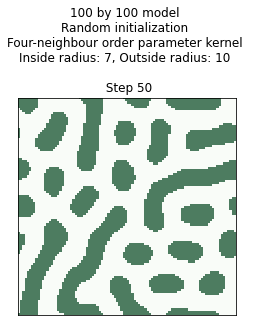

Button(description='Green Bubbles; (7, 10, 1)', style=ButtonStyle())

Button(description='Green Tubes; (7, 10, 1)', style=ButtonStyle())

Button(description='Mixed; (7, 10, 1)', style=ButtonStyle())

Button(description='White Bubbles; (7, 10, 1)', style=ButtonStyle())

Button(description='White Tubes; (7, 10, 1)', style=ButtonStyle())

Button(description='Error; (7, 10, 1)', style=ButtonStyle())

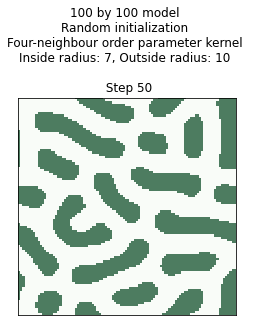

Button(description='Green Bubbles; (7, 10, 2)', style=ButtonStyle())

Button(description='Green Tubes; (7, 10, 2)', style=ButtonStyle())

Button(description='Mixed; (7, 10, 2)', style=ButtonStyle())

Button(description='White Bubbles; (7, 10, 2)', style=ButtonStyle())

Button(description='White Tubes; (7, 10, 2)', style=ButtonStyle())

Button(description='Error; (7, 10, 2)', style=ButtonStyle())

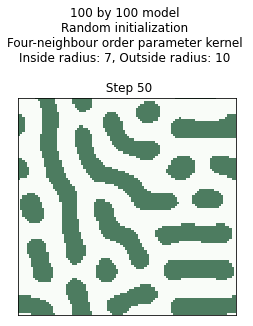

Button(description='Green Bubbles; (7, 10, 3)', style=ButtonStyle())

Button(description='Green Tubes; (7, 10, 3)', style=ButtonStyle())

Button(description='Mixed; (7, 10, 3)', style=ButtonStyle())

Button(description='White Bubbles; (7, 10, 3)', style=ButtonStyle())

Button(description='White Tubes; (7, 10, 3)', style=ButtonStyle())

Button(description='Error; (7, 10, 3)', style=ButtonStyle())

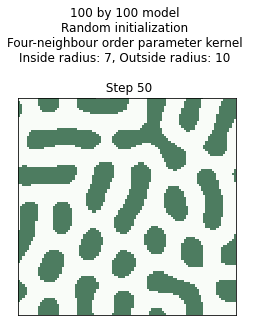

Button(description='Green Bubbles; (7, 10, 4)', style=ButtonStyle())

Button(description='Green Tubes; (7, 10, 4)', style=ButtonStyle())

Button(description='Mixed; (7, 10, 4)', style=ButtonStyle())

Button(description='White Bubbles; (7, 10, 4)', style=ButtonStyle())

Button(description='White Tubes; (7, 10, 4)', style=ButtonStyle())

Button(description='Error; (7, 10, 4)', style=ButtonStyle())

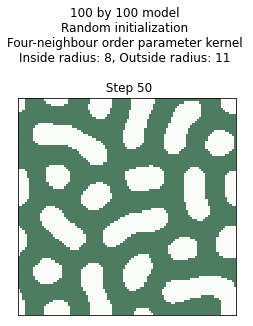

Button(description='Green Bubbles; (8, 11, 0)', style=ButtonStyle())

Button(description='Green Tubes; (8, 11, 0)', style=ButtonStyle())

Button(description='Mixed; (8, 11, 0)', style=ButtonStyle())

Button(description='White Bubbles; (8, 11, 0)', style=ButtonStyle())

Button(description='White Tubes; (8, 11, 0)', style=ButtonStyle())

Button(description='Error; (8, 11, 0)', style=ButtonStyle())

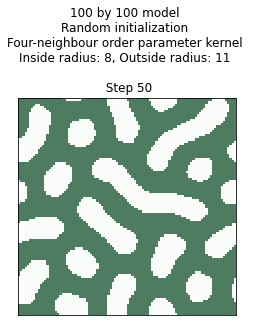

Button(description='Green Bubbles; (8, 11, 1)', style=ButtonStyle())

Button(description='Green Tubes; (8, 11, 1)', style=ButtonStyle())

Button(description='Mixed; (8, 11, 1)', style=ButtonStyle())

Button(description='White Bubbles; (8, 11, 1)', style=ButtonStyle())

Button(description='White Tubes; (8, 11, 1)', style=ButtonStyle())

Button(description='Error; (8, 11, 1)', style=ButtonStyle())

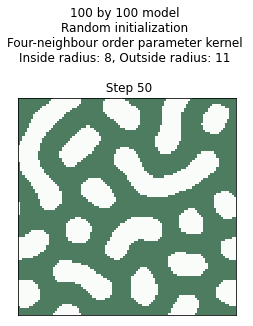

Button(description='Green Bubbles; (8, 11, 2)', style=ButtonStyle())

Button(description='Green Tubes; (8, 11, 2)', style=ButtonStyle())

Button(description='Mixed; (8, 11, 2)', style=ButtonStyle())

Button(description='White Bubbles; (8, 11, 2)', style=ButtonStyle())

Button(description='White Tubes; (8, 11, 2)', style=ButtonStyle())

Button(description='Error; (8, 11, 2)', style=ButtonStyle())

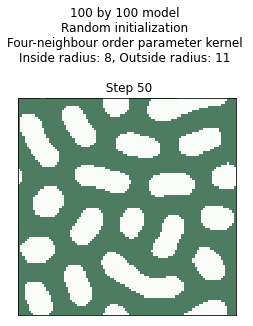

Button(description='Green Bubbles; (8, 11, 3)', style=ButtonStyle())

Button(description='Green Tubes; (8, 11, 3)', style=ButtonStyle())

Button(description='Mixed; (8, 11, 3)', style=ButtonStyle())

Button(description='White Bubbles; (8, 11, 3)', style=ButtonStyle())

Button(description='White Tubes; (8, 11, 3)', style=ButtonStyle())

Button(description='Error; (8, 11, 3)', style=ButtonStyle())

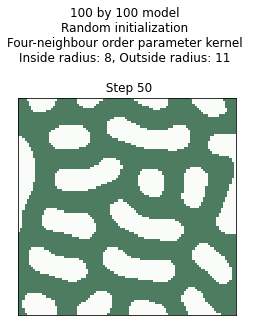

Button(description='Green Bubbles; (8, 11, 4)', style=ButtonStyle())

Button(description='Green Tubes; (8, 11, 4)', style=ButtonStyle())

Button(description='Mixed; (8, 11, 4)', style=ButtonStyle())

Button(description='White Bubbles; (8, 11, 4)', style=ButtonStyle())

Button(description='White Tubes; (8, 11, 4)', style=ButtonStyle())

Button(description='Error; (8, 11, 4)', style=ButtonStyle())

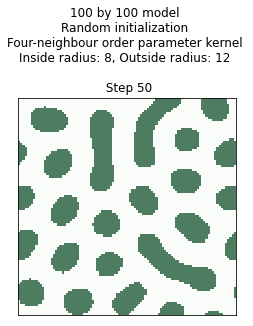

Button(description='Green Bubbles; (8, 12, 0)', style=ButtonStyle())

Button(description='Green Tubes; (8, 12, 0)', style=ButtonStyle())

Button(description='Mixed; (8, 12, 0)', style=ButtonStyle())

Button(description='White Bubbles; (8, 12, 0)', style=ButtonStyle())

Button(description='White Tubes; (8, 12, 0)', style=ButtonStyle())

Button(description='Error; (8, 12, 0)', style=ButtonStyle())

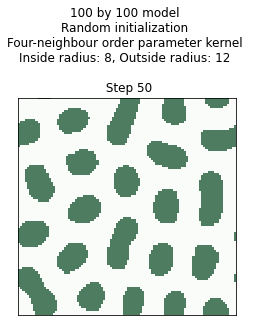

Button(description='Green Bubbles; (8, 12, 1)', style=ButtonStyle())

Button(description='Green Tubes; (8, 12, 1)', style=ButtonStyle())

Button(description='Mixed; (8, 12, 1)', style=ButtonStyle())

Button(description='White Bubbles; (8, 12, 1)', style=ButtonStyle())

Button(description='White Tubes; (8, 12, 1)', style=ButtonStyle())

Button(description='Error; (8, 12, 1)', style=ButtonStyle())

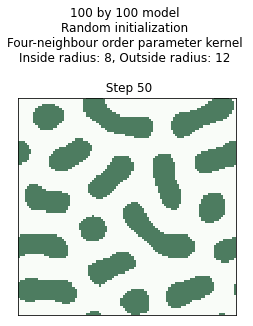

Button(description='Green Bubbles; (8, 12, 2)', style=ButtonStyle())

Button(description='Green Tubes; (8, 12, 2)', style=ButtonStyle())

Button(description='Mixed; (8, 12, 2)', style=ButtonStyle())

Button(description='White Bubbles; (8, 12, 2)', style=ButtonStyle())

Button(description='White Tubes; (8, 12, 2)', style=ButtonStyle())

Button(description='Error; (8, 12, 2)', style=ButtonStyle())

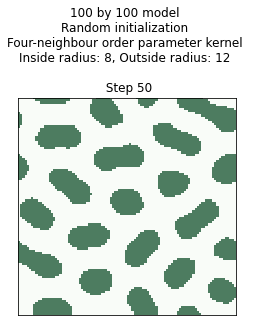

Button(description='Green Bubbles; (8, 12, 3)', style=ButtonStyle())

Button(description='Green Tubes; (8, 12, 3)', style=ButtonStyle())

Button(description='Mixed; (8, 12, 3)', style=ButtonStyle())

Button(description='White Bubbles; (8, 12, 3)', style=ButtonStyle())

Button(description='White Tubes; (8, 12, 3)', style=ButtonStyle())

Button(description='Error; (8, 12, 3)', style=ButtonStyle())

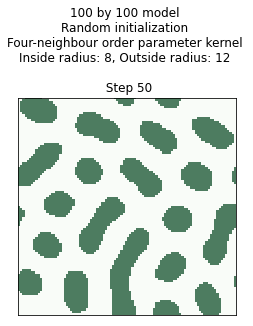

Button(description='Green Bubbles; (8, 12, 4)', style=ButtonStyle())

Button(description='Green Tubes; (8, 12, 4)', style=ButtonStyle())

Button(description='Mixed; (8, 12, 4)', style=ButtonStyle())

Button(description='White Bubbles; (8, 12, 4)', style=ButtonStyle())

Button(description='White Tubes; (8, 12, 4)', style=ButtonStyle())

Button(description='Error; (8, 12, 4)', style=ButtonStyle())

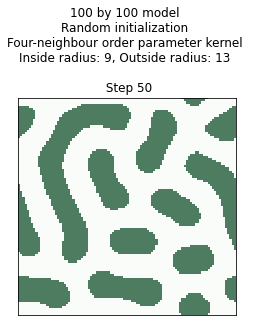

Button(description='Green Bubbles; (9, 13, 0)', style=ButtonStyle())

Button(description='Green Tubes; (9, 13, 0)', style=ButtonStyle())

Button(description='Mixed; (9, 13, 0)', style=ButtonStyle())

Button(description='White Bubbles; (9, 13, 0)', style=ButtonStyle())

Button(description='White Tubes; (9, 13, 0)', style=ButtonStyle())

Button(description='Error; (9, 13, 0)', style=ButtonStyle())

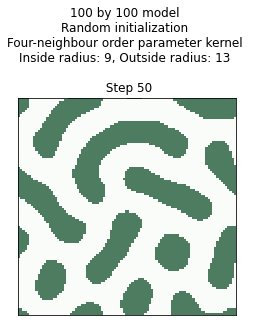

Button(description='Green Bubbles; (9, 13, 1)', style=ButtonStyle())

Button(description='Green Tubes; (9, 13, 1)', style=ButtonStyle())

Button(description='Mixed; (9, 13, 1)', style=ButtonStyle())

Button(description='White Bubbles; (9, 13, 1)', style=ButtonStyle())

Button(description='White Tubes; (9, 13, 1)', style=ButtonStyle())

Button(description='Error; (9, 13, 1)', style=ButtonStyle())

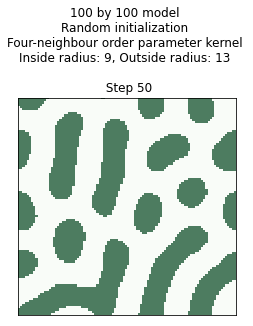

Button(description='Green Bubbles; (9, 13, 2)', style=ButtonStyle())

Button(description='Green Tubes; (9, 13, 2)', style=ButtonStyle())

Button(description='Mixed; (9, 13, 2)', style=ButtonStyle())

Button(description='White Bubbles; (9, 13, 2)', style=ButtonStyle())

Button(description='White Tubes; (9, 13, 2)', style=ButtonStyle())

Button(description='Error; (9, 13, 2)', style=ButtonStyle())

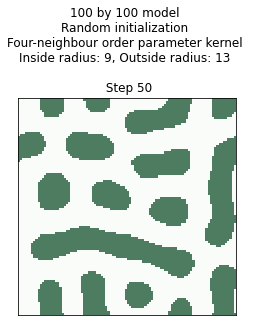

Button(description='Green Bubbles; (9, 13, 3)', style=ButtonStyle())

Button(description='Green Tubes; (9, 13, 3)', style=ButtonStyle())

Button(description='Mixed; (9, 13, 3)', style=ButtonStyle())

Button(description='White Bubbles; (9, 13, 3)', style=ButtonStyle())

Button(description='White Tubes; (9, 13, 3)', style=ButtonStyle())

Button(description='Error; (9, 13, 3)', style=ButtonStyle())

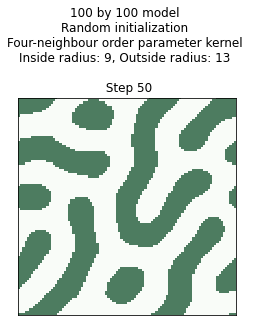

Button(description='Green Bubbles; (9, 13, 4)', style=ButtonStyle())

Button(description='Green Tubes; (9, 13, 4)', style=ButtonStyle())

Button(description='Mixed; (9, 13, 4)', style=ButtonStyle())

Button(description='White Bubbles; (9, 13, 4)', style=ButtonStyle())

Button(description='White Tubes; (9, 13, 4)', style=ButtonStyle())

Button(description='Error; (9, 13, 4)', style=ButtonStyle())

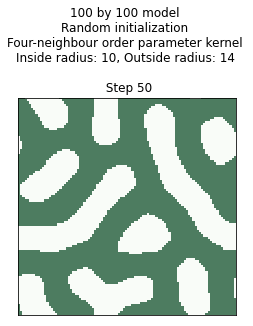

Button(description='Green Bubbles; (10, 14, 0)', style=ButtonStyle())

Button(description='Green Tubes; (10, 14, 0)', style=ButtonStyle())

Button(description='Mixed; (10, 14, 0)', style=ButtonStyle())

Button(description='White Bubbles; (10, 14, 0)', style=ButtonStyle())

Button(description='White Tubes; (10, 14, 0)', style=ButtonStyle())

Button(description='Error; (10, 14, 0)', style=ButtonStyle())

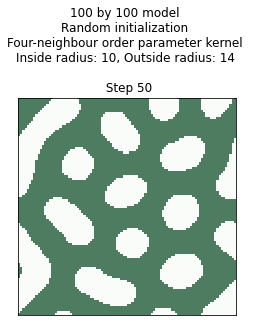

Button(description='Green Bubbles; (10, 14, 1)', style=ButtonStyle())

Button(description='Green Tubes; (10, 14, 1)', style=ButtonStyle())

Button(description='Mixed; (10, 14, 1)', style=ButtonStyle())

Button(description='White Bubbles; (10, 14, 1)', style=ButtonStyle())

Button(description='White Tubes; (10, 14, 1)', style=ButtonStyle())

Button(description='Error; (10, 14, 1)', style=ButtonStyle())

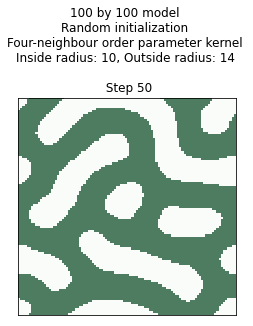

Button(description='Green Bubbles; (10, 14, 2)', style=ButtonStyle())

Button(description='Green Tubes; (10, 14, 2)', style=ButtonStyle())

Button(description='Mixed; (10, 14, 2)', style=ButtonStyle())

Button(description='White Bubbles; (10, 14, 2)', style=ButtonStyle())

Button(description='White Tubes; (10, 14, 2)', style=ButtonStyle())

Button(description='Error; (10, 14, 2)', style=ButtonStyle())

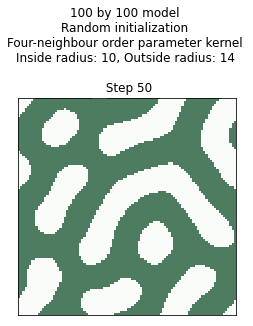

Button(description='Green Bubbles; (10, 14, 3)', style=ButtonStyle())

Button(description='Green Tubes; (10, 14, 3)', style=ButtonStyle())

Button(description='Mixed; (10, 14, 3)', style=ButtonStyle())

Button(description='White Bubbles; (10, 14, 3)', style=ButtonStyle())

Button(description='White Tubes; (10, 14, 3)', style=ButtonStyle())

Button(description='Error; (10, 14, 3)', style=ButtonStyle())

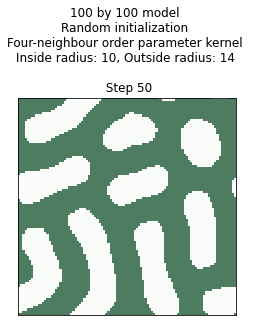

Button(description='Green Bubbles; (10, 14, 4)', style=ButtonStyle())

Button(description='Green Tubes; (10, 14, 4)', style=ButtonStyle())

Button(description='Mixed; (10, 14, 4)', style=ButtonStyle())

Button(description='White Bubbles; (10, 14, 4)', style=ButtonStyle())

Button(description='White Tubes; (10, 14, 4)', style=ButtonStyle())

Button(description='Error; (10, 14, 4)', style=ButtonStyle())

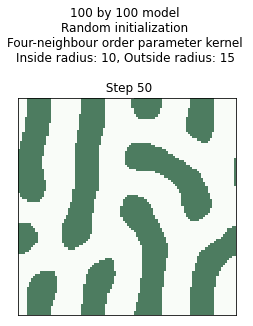

Button(description='Green Bubbles; (10, 15, 0)', style=ButtonStyle())

Button(description='Green Tubes; (10, 15, 0)', style=ButtonStyle())

Button(description='Mixed; (10, 15, 0)', style=ButtonStyle())

Button(description='White Bubbles; (10, 15, 0)', style=ButtonStyle())

Button(description='White Tubes; (10, 15, 0)', style=ButtonStyle())

Button(description='Error; (10, 15, 0)', style=ButtonStyle())

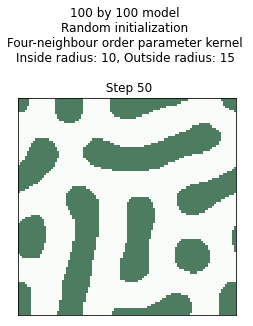

Button(description='Green Bubbles; (10, 15, 1)', style=ButtonStyle())

Button(description='Green Tubes; (10, 15, 1)', style=ButtonStyle())

Button(description='Mixed; (10, 15, 1)', style=ButtonStyle())

Button(description='White Bubbles; (10, 15, 1)', style=ButtonStyle())

Button(description='White Tubes; (10, 15, 1)', style=ButtonStyle())

Button(description='Error; (10, 15, 1)', style=ButtonStyle())

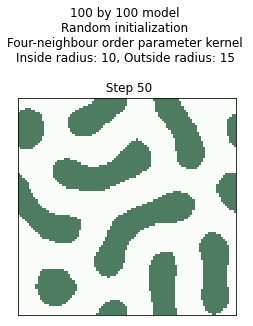

Button(description='Green Bubbles; (10, 15, 2)', style=ButtonStyle())

Button(description='Green Tubes; (10, 15, 2)', style=ButtonStyle())

Button(description='Mixed; (10, 15, 2)', style=ButtonStyle())

Button(description='White Bubbles; (10, 15, 2)', style=ButtonStyle())

Button(description='White Tubes; (10, 15, 2)', style=ButtonStyle())

Button(description='Error; (10, 15, 2)', style=ButtonStyle())

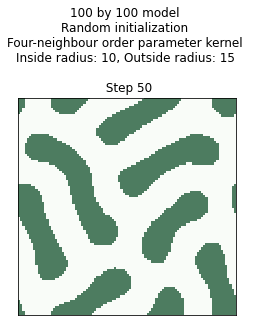

Button(description='Green Bubbles; (10, 15, 3)', style=ButtonStyle())

Button(description='Green Tubes; (10, 15, 3)', style=ButtonStyle())

Button(description='Mixed; (10, 15, 3)', style=ButtonStyle())

Button(description='White Bubbles; (10, 15, 3)', style=ButtonStyle())

Button(description='White Tubes; (10, 15, 3)', style=ButtonStyle())

Button(description='Error; (10, 15, 3)', style=ButtonStyle())

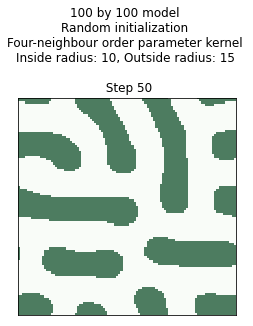

Button(description='Green Bubbles; (10, 15, 4)', style=ButtonStyle())

Button(description='Green Tubes; (10, 15, 4)', style=ButtonStyle())

Button(description='Mixed; (10, 15, 4)', style=ButtonStyle())

Button(description='White Bubbles; (10, 15, 4)', style=ButtonStyle())

Button(description='White Tubes; (10, 15, 4)', style=ButtonStyle())

Button(description='Error; (10, 15, 4)', style=ButtonStyle())

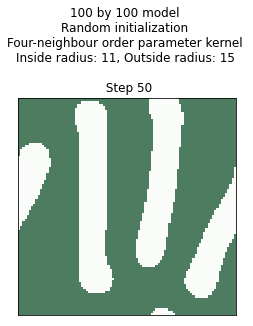

Button(description='Green Bubbles; (11, 15, 0)', style=ButtonStyle())

Button(description='Green Tubes; (11, 15, 0)', style=ButtonStyle())

Button(description='Mixed; (11, 15, 0)', style=ButtonStyle())

Button(description='White Bubbles; (11, 15, 0)', style=ButtonStyle())

Button(description='White Tubes; (11, 15, 0)', style=ButtonStyle())

Button(description='Error; (11, 15, 0)', style=ButtonStyle())

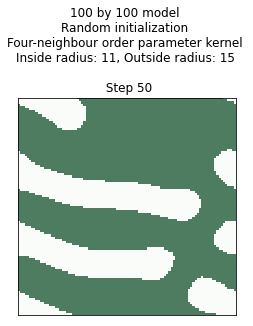

Button(description='Green Bubbles; (11, 15, 1)', style=ButtonStyle())

Button(description='Green Tubes; (11, 15, 1)', style=ButtonStyle())

Button(description='Mixed; (11, 15, 1)', style=ButtonStyle())

Button(description='White Bubbles; (11, 15, 1)', style=ButtonStyle())

Button(description='White Tubes; (11, 15, 1)', style=ButtonStyle())

Button(description='Error; (11, 15, 1)', style=ButtonStyle())

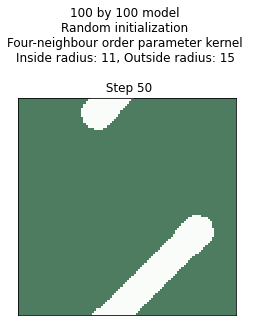

Button(description='Green Bubbles; (11, 15, 2)', style=ButtonStyle())

Button(description='Green Tubes; (11, 15, 2)', style=ButtonStyle())

Button(description='Mixed; (11, 15, 2)', style=ButtonStyle())

Button(description='White Bubbles; (11, 15, 2)', style=ButtonStyle())

Button(description='White Tubes; (11, 15, 2)', style=ButtonStyle())

Button(description='Error; (11, 15, 2)', style=ButtonStyle())

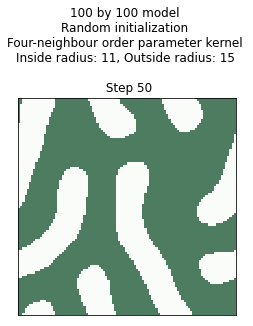

Button(description='Green Bubbles; (11, 15, 3)', style=ButtonStyle())

Button(description='Green Tubes; (11, 15, 3)', style=ButtonStyle())

Button(description='Mixed; (11, 15, 3)', style=ButtonStyle())

Button(description='White Bubbles; (11, 15, 3)', style=ButtonStyle())

Button(description='White Tubes; (11, 15, 3)', style=ButtonStyle())

Button(description='Error; (11, 15, 3)', style=ButtonStyle())

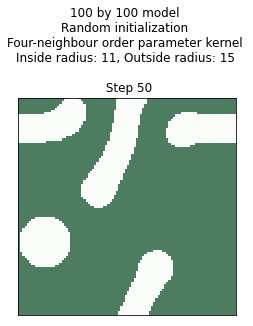

Button(description='Green Bubbles; (11, 15, 4)', style=ButtonStyle())

Button(description='Green Tubes; (11, 15, 4)', style=ButtonStyle())

Button(description='Mixed; (11, 15, 4)', style=ButtonStyle())

Button(description='White Bubbles; (11, 15, 4)', style=ButtonStyle())

Button(description='White Tubes; (11, 15, 4)', style=ButtonStyle())

Button(description='Error; (11, 15, 4)', style=ButtonStyle())

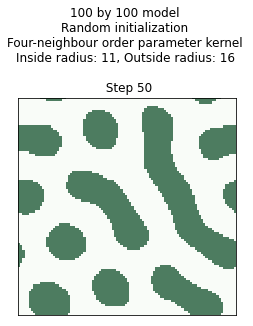

Button(description='Green Bubbles; (11, 16, 0)', style=ButtonStyle())

Button(description='Green Tubes; (11, 16, 0)', style=ButtonStyle())

Button(description='Mixed; (11, 16, 0)', style=ButtonStyle())

Button(description='White Bubbles; (11, 16, 0)', style=ButtonStyle())

Button(description='White Tubes; (11, 16, 0)', style=ButtonStyle())

Button(description='Error; (11, 16, 0)', style=ButtonStyle())

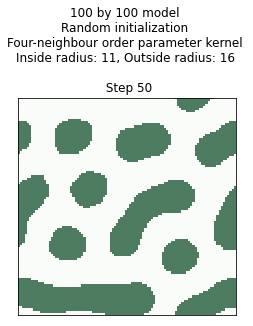

Button(description='Green Bubbles; (11, 16, 1)', style=ButtonStyle())

Button(description='Green Tubes; (11, 16, 1)', style=ButtonStyle())

Button(description='Mixed; (11, 16, 1)', style=ButtonStyle())

Button(description='White Bubbles; (11, 16, 1)', style=ButtonStyle())

Button(description='White Tubes; (11, 16, 1)', style=ButtonStyle())

Button(description='Error; (11, 16, 1)', style=ButtonStyle())

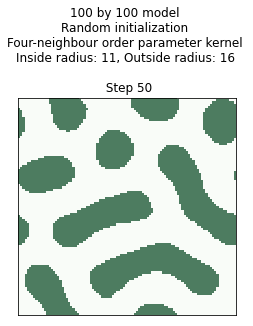

Button(description='Green Bubbles; (11, 16, 2)', style=ButtonStyle())

Button(description='Green Tubes; (11, 16, 2)', style=ButtonStyle())

Button(description='Mixed; (11, 16, 2)', style=ButtonStyle())

Button(description='White Bubbles; (11, 16, 2)', style=ButtonStyle())

Button(description='White Tubes; (11, 16, 2)', style=ButtonStyle())

Button(description='Error; (11, 16, 2)', style=ButtonStyle())

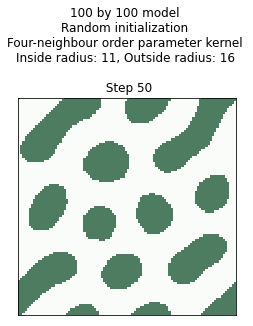

Button(description='Green Bubbles; (11, 16, 3)', style=ButtonStyle())

Button(description='Green Tubes; (11, 16, 3)', style=ButtonStyle())

Button(description='Mixed; (11, 16, 3)', style=ButtonStyle())

Button(description='White Bubbles; (11, 16, 3)', style=ButtonStyle())

Button(description='White Tubes; (11, 16, 3)', style=ButtonStyle())

Button(description='Error; (11, 16, 3)', style=ButtonStyle())

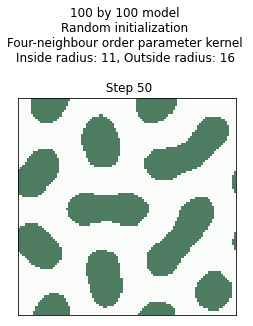

Button(description='Green Bubbles; (11, 16, 4)', style=ButtonStyle())

Button(description='Green Tubes; (11, 16, 4)', style=ButtonStyle())

Button(description='Mixed; (11, 16, 4)', style=ButtonStyle())

Button(description='White Bubbles; (11, 16, 4)', style=ButtonStyle())

Button(description='White Tubes; (11, 16, 4)', style=ButtonStyle())

Button(description='Error; (11, 16, 4)', style=ButtonStyle())

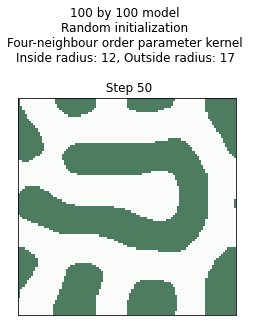

Button(description='Green Bubbles; (12, 17, 0)', style=ButtonStyle())

Button(description='Green Tubes; (12, 17, 0)', style=ButtonStyle())

Button(description='Mixed; (12, 17, 0)', style=ButtonStyle())

Button(description='White Bubbles; (12, 17, 0)', style=ButtonStyle())

Button(description='White Tubes; (12, 17, 0)', style=ButtonStyle())

Button(description='Error; (12, 17, 0)', style=ButtonStyle())

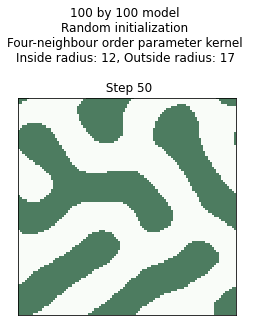

Button(description='Green Bubbles; (12, 17, 1)', style=ButtonStyle())

Button(description='Green Tubes; (12, 17, 1)', style=ButtonStyle())

Button(description='Mixed; (12, 17, 1)', style=ButtonStyle())

Button(description='White Bubbles; (12, 17, 1)', style=ButtonStyle())

Button(description='White Tubes; (12, 17, 1)', style=ButtonStyle())

Button(description='Error; (12, 17, 1)', style=ButtonStyle())

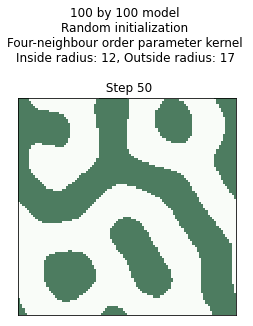

Button(description='Green Bubbles; (12, 17, 2)', style=ButtonStyle())

Button(description='Green Tubes; (12, 17, 2)', style=ButtonStyle())

Button(description='Mixed; (12, 17, 2)', style=ButtonStyle())

Button(description='White Bubbles; (12, 17, 2)', style=ButtonStyle())

Button(description='White Tubes; (12, 17, 2)', style=ButtonStyle())

Button(description='Error; (12, 17, 2)', style=ButtonStyle())

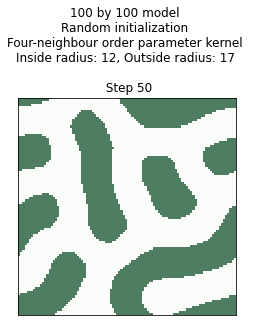

Button(description='Green Bubbles; (12, 17, 3)', style=ButtonStyle())

Button(description='Green Tubes; (12, 17, 3)', style=ButtonStyle())

Button(description='Mixed; (12, 17, 3)', style=ButtonStyle())

Button(description='White Bubbles; (12, 17, 3)', style=ButtonStyle())

Button(description='White Tubes; (12, 17, 3)', style=ButtonStyle())

Button(description='Error; (12, 17, 3)', style=ButtonStyle())

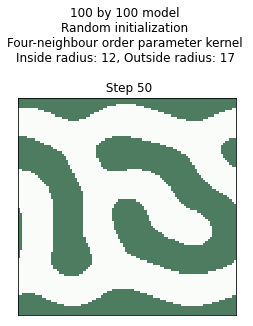

Button(description='Green Bubbles; (12, 17, 4)', style=ButtonStyle())

Button(description='Green Tubes; (12, 17, 4)', style=ButtonStyle())

Button(description='Mixed; (12, 17, 4)', style=ButtonStyle())

Button(description='White Bubbles; (12, 17, 4)', style=ButtonStyle())

Button(description='White Tubes; (12, 17, 4)', style=ButtonStyle())

Button(description='Error; (12, 17, 4)', style=ButtonStyle())

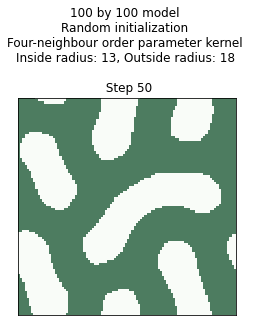

Button(description='Green Bubbles; (13, 18, 0)', style=ButtonStyle())

Button(description='Green Tubes; (13, 18, 0)', style=ButtonStyle())

Button(description='Mixed; (13, 18, 0)', style=ButtonStyle())

Button(description='White Bubbles; (13, 18, 0)', style=ButtonStyle())

Button(description='White Tubes; (13, 18, 0)', style=ButtonStyle())

Button(description='Error; (13, 18, 0)', style=ButtonStyle())

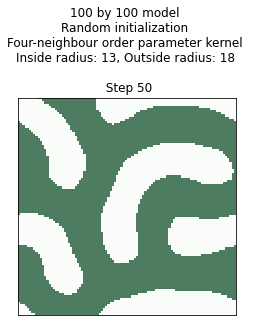

Button(description='Green Bubbles; (13, 18, 1)', style=ButtonStyle())

Button(description='Green Tubes; (13, 18, 1)', style=ButtonStyle())

Button(description='Mixed; (13, 18, 1)', style=ButtonStyle())

Button(description='White Bubbles; (13, 18, 1)', style=ButtonStyle())

Button(description='White Tubes; (13, 18, 1)', style=ButtonStyle())

Button(description='Error; (13, 18, 1)', style=ButtonStyle())

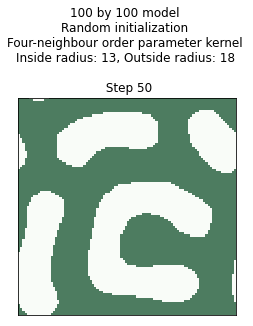

Button(description='Green Bubbles; (13, 18, 2)', style=ButtonStyle())

Button(description='Green Tubes; (13, 18, 2)', style=ButtonStyle())

Button(description='Mixed; (13, 18, 2)', style=ButtonStyle())

Button(description='White Bubbles; (13, 18, 2)', style=ButtonStyle())

Button(description='White Tubes; (13, 18, 2)', style=ButtonStyle())

Button(description='Error; (13, 18, 2)', style=ButtonStyle())

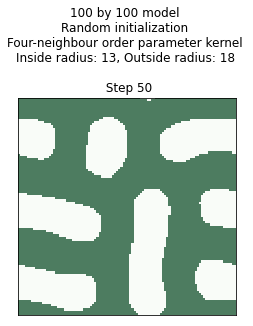

Button(description='Green Bubbles; (13, 18, 3)', style=ButtonStyle())

Button(description='Green Tubes; (13, 18, 3)', style=ButtonStyle())

Button(description='Mixed; (13, 18, 3)', style=ButtonStyle())

Button(description='White Bubbles; (13, 18, 3)', style=ButtonStyle())

Button(description='White Tubes; (13, 18, 3)', style=ButtonStyle())

Button(description='Error; (13, 18, 3)', style=ButtonStyle())

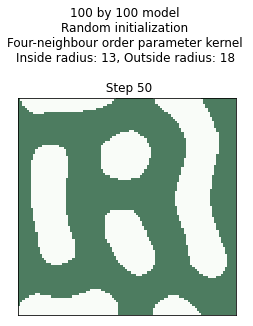

Button(description='Green Bubbles; (13, 18, 4)', style=ButtonStyle())

Button(description='Green Tubes; (13, 18, 4)', style=ButtonStyle())

Button(description='Mixed; (13, 18, 4)', style=ButtonStyle())

Button(description='White Bubbles; (13, 18, 4)', style=ButtonStyle())

Button(description='White Tubes; (13, 18, 4)', style=ButtonStyle())

Button(description='Error; (13, 18, 4)', style=ButtonStyle())

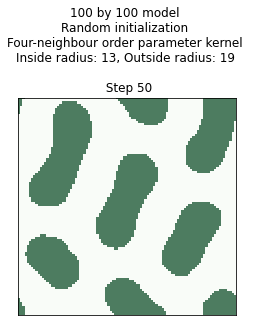

Button(description='Green Bubbles; (13, 19, 0)', style=ButtonStyle())

Button(description='Green Tubes; (13, 19, 0)', style=ButtonStyle())

Button(description='Mixed; (13, 19, 0)', style=ButtonStyle())

Button(description='White Bubbles; (13, 19, 0)', style=ButtonStyle())

Button(description='White Tubes; (13, 19, 0)', style=ButtonStyle())

Button(description='Error; (13, 19, 0)', style=ButtonStyle())

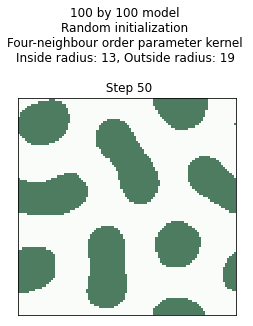

Button(description='Green Bubbles; (13, 19, 1)', style=ButtonStyle())

Button(description='Green Tubes; (13, 19, 1)', style=ButtonStyle())

Button(description='Mixed; (13, 19, 1)', style=ButtonStyle())

Button(description='White Bubbles; (13, 19, 1)', style=ButtonStyle())

Button(description='White Tubes; (13, 19, 1)', style=ButtonStyle())

Button(description='Error; (13, 19, 1)', style=ButtonStyle())

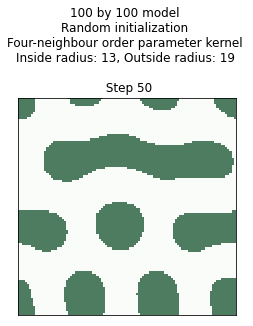

Button(description='Green Bubbles; (13, 19, 2)', style=ButtonStyle())

Button(description='Green Tubes; (13, 19, 2)', style=ButtonStyle())

Button(description='Mixed; (13, 19, 2)', style=ButtonStyle())

Button(description='White Bubbles; (13, 19, 2)', style=ButtonStyle())

Button(description='White Tubes; (13, 19, 2)', style=ButtonStyle())

Button(description='Error; (13, 19, 2)', style=ButtonStyle())

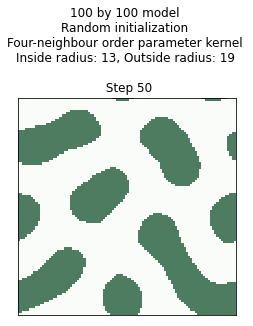

Button(description='Green Bubbles; (13, 19, 3)', style=ButtonStyle())

Button(description='Green Tubes; (13, 19, 3)', style=ButtonStyle())

Button(description='Mixed; (13, 19, 3)', style=ButtonStyle())

Button(description='White Bubbles; (13, 19, 3)', style=ButtonStyle())

Button(description='White Tubes; (13, 19, 3)', style=ButtonStyle())

Button(description='Error; (13, 19, 3)', style=ButtonStyle())

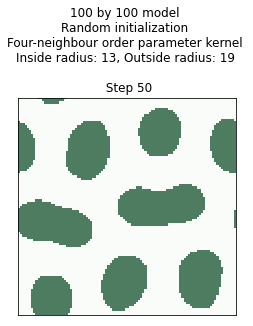

Button(description='Green Bubbles; (13, 19, 4)', style=ButtonStyle())

Button(description='Green Tubes; (13, 19, 4)', style=ButtonStyle())

Button(description='Mixed; (13, 19, 4)', style=ButtonStyle())

Button(description='White Bubbles; (13, 19, 4)', style=ButtonStyle())

Button(description='White Tubes; (13, 19, 4)', style=ButtonStyle())

Button(description='Error; (13, 19, 4)', style=ButtonStyle())

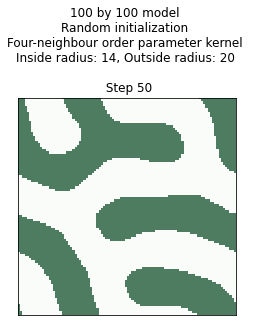

Button(description='Green Bubbles; (14, 20, 0)', style=ButtonStyle())

Button(description='Green Tubes; (14, 20, 0)', style=ButtonStyle())

Button(description='Mixed; (14, 20, 0)', style=ButtonStyle())

Button(description='White Bubbles; (14, 20, 0)', style=ButtonStyle())

Button(description='White Tubes; (14, 20, 0)', style=ButtonStyle())

Button(description='Error; (14, 20, 0)', style=ButtonStyle())

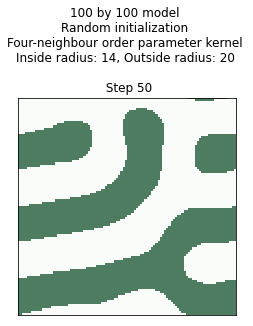

Button(description='Green Bubbles; (14, 20, 1)', style=ButtonStyle())

Button(description='Green Tubes; (14, 20, 1)', style=ButtonStyle())

Button(description='Mixed; (14, 20, 1)', style=ButtonStyle())

Button(description='White Bubbles; (14, 20, 1)', style=ButtonStyle())

Button(description='White Tubes; (14, 20, 1)', style=ButtonStyle())

Button(description='Error; (14, 20, 1)', style=ButtonStyle())

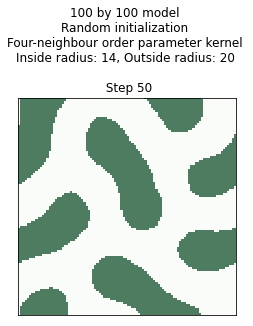

Button(description='Green Bubbles; (14, 20, 2)', style=ButtonStyle())

Button(description='Green Tubes; (14, 20, 2)', style=ButtonStyle())

Button(description='Mixed; (14, 20, 2)', style=ButtonStyle())

Button(description='White Bubbles; (14, 20, 2)', style=ButtonStyle())

Button(description='White Tubes; (14, 20, 2)', style=ButtonStyle())

Button(description='Error; (14, 20, 2)', style=ButtonStyle())

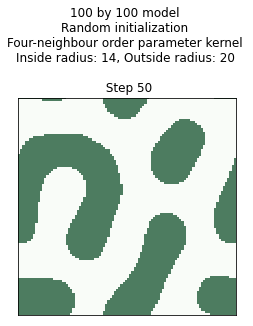

Button(description='Green Bubbles; (14, 20, 3)', style=ButtonStyle())

Button(description='Green Tubes; (14, 20, 3)', style=ButtonStyle())

Button(description='Mixed; (14, 20, 3)', style=ButtonStyle())

Button(description='White Bubbles; (14, 20, 3)', style=ButtonStyle())

Button(description='White Tubes; (14, 20, 3)', style=ButtonStyle())

Button(description='Error; (14, 20, 3)', style=ButtonStyle())

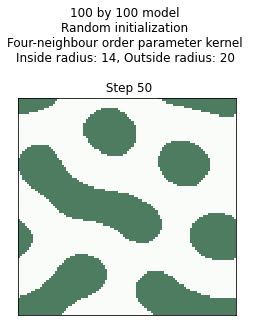

Button(description='Green Bubbles; (14, 20, 4)', style=ButtonStyle())

Button(description='Green Tubes; (14, 20, 4)', style=ButtonStyle())

Button(description='Mixed; (14, 20, 4)', style=ButtonStyle())

Button(description='White Bubbles; (14, 20, 4)', style=ButtonStyle())

Button(description='White Tubes; (14, 20, 4)', style=ButtonStyle())

Button(description='Error; (14, 20, 4)', style=ButtonStyle())

Button(button_style='warning', description='Submit', style=ButtonStyle())

{'Green Bubbles': [0.0, 0.0, 0.0, 0.0, 0.0, 0.06, 0.05, 0.04, 0.05, 0.06, 0.31, 0.32, 0.32, 0.33, 0.34, 0.34, 0.34, 0.34, 0.35, 0.4], 'Green Tubes': [0.33, 0.33, 0.32, 0.34, 0.34, 0.34, 0.39, 0.4, 0.41, 0.36, 0.4, 0.41, 0.43, 0.4, 0.38, 0.38, 0.39, 0.39, 0.44, 0.45, 0.45, 0.44, 0.46, 0.38, 0.37, 0.38, 0.38, 0.47, 0.47, 0.42, 0.42, 0.41], 'Mixed': [0.32, 0.34, 0.35, 0.39, 0.4, 0.63, 0.62, 0.35, 0.4, 0.59, 0.38, 0.39, 0.39, 0.38, 0.37, 0.36], 'White Tubes': [0.62, 0.62, 0.58, 0.58, 0.58, 0.68, 0.69, 0.89, 0.64, 0.76, 0.61, 0.58, 0.6, 0.61, 0.61], 'White Bubbles': [0.81, 0.84, 0.82, 0.82, 0.8, 0.63, 0.62]}


In [30]:
test_data = valid_parameters[0]

iterations = 5
button_dict = {}
areas = {
          'Green Bubbles': [],
          'Green Tubes': [],
          'Mixed': [],
          'White Tubes': [],
          'White Bubbles': []
        }

def clicked(arg):   
    string = arg.description.split('; ')[0]
    index = arg.description.split('; ')[1].replace('(', '').replace(')', '').split(',')
    
    arg.button_style = 'success'
    if 'Error' in arg.description:
        arg.button_style = 'danger'
    
    ri, ro, i = int(index[0]), int(index[1]), int(index[2])
    index = f'{(ri, ro)}'
    buttons = button_dict[index][i][0]
    area = button_dict[index][i][1]
    
    
    for button in buttons:
        button.disabled = True
        
    if not string == 'Error': 
        areas[string].append(area)
        

def submitted(arg):       
    print(areas)
    
    
for i in test_data:
    
    index = f'{(i[0], i[1])}'
    button_dict[index] = []
    
    for iteration in range(iterations):
        a = ReactionDiffusion(100, i[0], i[1])
        a.loop(50)
        a.draw()
        plt.show()

        identifier = (i[0], i[1], iteration)
        greenSpheres = widgets.Button(description = f'Green Bubbles; {identifier}')
        greenTubes = widgets.Button(description = f'Green Tubes; {identifier}')   
        mixed = widgets.Button(description = f'Mixed; {identifier}')  
        whiteTubes = widgets.Button(description = f'White Tubes; {identifier}')   
        whiteSpheres = widgets.Button(description = f'White Bubbles; {identifier}')  
        nothing = widgets.Button(description = f'Error; {identifier}')
        
        buttons = [greenSpheres, greenTubes, mixed, whiteSpheres, whiteTubes, nothing]
        button_dict[index].append((buttons, a.area))

        for button in buttons:
            button.on_click(clicked)
            display(button)

            
submit = widgets.Button(description = 'Submit', button_style='warning')
submit.on_click(submitted)
display(submit)

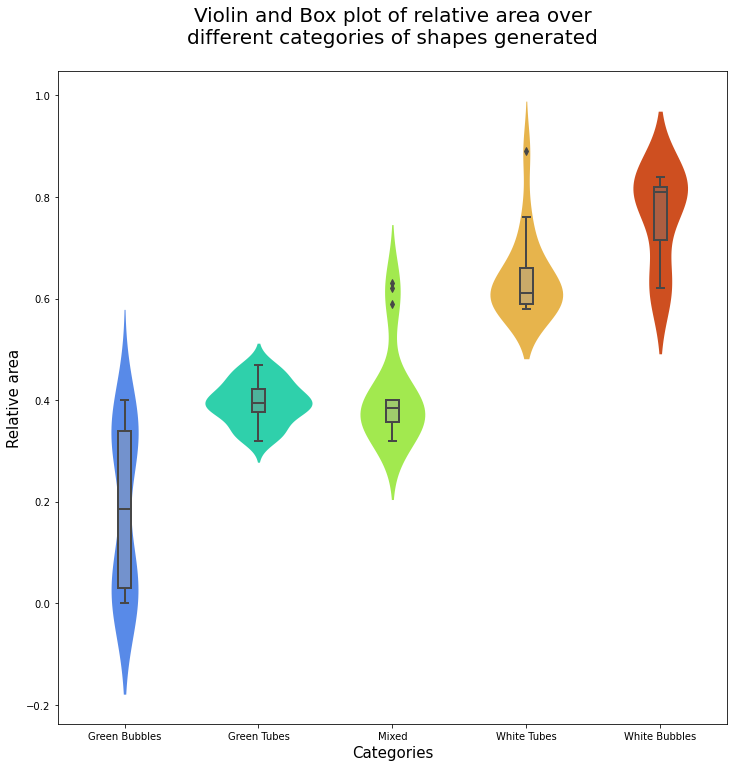

In [31]:
plotting2 = [i for i in areas.values()]

fig = plt.figure(figsize=(12, 12))
ax = sns.violinplot(data = plotting2, palette='turbo',
                    inner=None, linewidth=0, saturation=0.8)
ax = sns.boxplot(data=plotting2, palette='turbo', width=0.1,
            boxprops={'zorder': 2}, ax=ax, saturation=0.5)


ax.set_xticklabels([i for i in areas.keys()], rotation=0, size=10)
ax.set_xlabel('Categories', size=15)
ax.set_ylabel('Relative area', size=15)
ax.set_title("Violin and Box plot of relative area over\ndifferent categories of shapes generated\n", size=20)



plt.show()